# EIA Project

Following a summary of the project. For more details, go to the report

**About the EIA**

The U.S. Energy Information Administration (EIA) is a government agency within the U.S. Department of Energy that collects, analyzes, and publishes independent and impartial energy information.
Its mission is to promote sound policymaking, efficient markets, and public understanding of energy and its interaction with the economy and the environment.

The EIA provides comprehensive data on petroleum, natural gas, coal, electricity, renewables, and nuclear energy with production, consumption, imports/exports, inventories, prices, regular reports such as the Weekly Petroleum Status Report (WPSR), Short-Term Energy Outlook, and Annual Energy Outlook.

For oil markets, the Weekly Petroleum Status Report is a key source of market fundamentals, summarizing U.S. crude oil and petroleum product supply, demand, and inventory levels — data closely followed by traders, analysts, and policy makers for its potential to influence market sentiment and decision-making.

Source: https://www.eia.gov/

**Business Problem**

An energy trading desk wants to understand which petroleum market fundamentals have the most influence on WTI spot prices, so they can prioritize monitoring and risk assessments on the most impactful indicators.

By identifying and quantifying these relationships, the desk can improve market awareness, refine hedging strategies, and enhance the efficiency of internal reporting.

**Business Question**

Which petroleum market fundamentals reported in the EIA’s Weekly Petroleum Status Report have the strongest historical influence on weekly average WTI spot prices?

**Stakeholders**

-	Trading desk: to allocate research resources toward the most relevant fundamentals.
- Market analysts: to focus daily commentary on key drivers.
- Risk management team: to incorporate key fundamentals into stress tests and VaR scenarios.
- Executives: to understand high-level market dynamics without deep technical knowledge.


**Business Objectives**

1.	Build a machine learning model to explain weekly average WTI spot price using petroleum market fundamentals from the EIA’s Weekly Petroleum Status Report (WPSR).
2.	Rank the importance of each feature in explaining historical price variation.
3.	Deliver actionable recommendations on which fundamentals to track most closely for market monitoring.


**Metrics**

Technical:
-	R² and MAE for in-sample model fit (to confirm model quality).
-	Feature importance rankings and interpretability metrics.

Business:

-	Clarity of insights for non-technical stakeholders.
-	Ability to produce a prioritized driver list that matches market intuition.


**Type of Modeling**

•	Regression (supervised learning) with emphasis on explanatory power.

•	Potential algorithms: Linear Regression, Lasso/Ridge, Random Forest Regressor, XGBoost Regressor.

•	Focus on interpretability alongside model fit quality (R², MAE).

**Dataset**

Source: U.S. Energy Information Administration (EIA) — Weekly Petroleum Status Report (WPSR) and related datasets.

Frequency: Weekly.

Period: ~30 years (if available) for robust statistical learning.

Target variable: EIA Weekly Average WTI spot price (Cushing, OK).

Features:

-	U.S. crude oil stocks (ex-SPR)
-	Total motor gasoline stocks
-	Distillate fuel oil stocks
-	Total product supplied
-	Refinery capacity utilization (%)
-	Crude oil production (U.S.)
-	Net imports/exports of crude and products
-	Seasonal indicator (week of year)

**Evaluation Plan**

1.	EDA to explore relationships between fundamentals and price.
2.	Model fitting with cross-validation for robustness.
3.	Feature importance analysis.
4.	Business interpretation — map statistical importance to actionable insights.

# Imports + Config

In [1]:
from pathlib import Path
import pandas as pd
import re, textwrap, os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import statsmodels.api as sm

In [2]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')
BASE = Path('/content/drive/MyDrive/Colab Notebooks/EIA')

Mounted at /content/drive


I will uses a master mapping file to get the right data

In [4]:
# Load master mapping

mapping = pd.read_excel(BASE / "index_eia.xlsx")
mapping.columns = [c.strip().lower() for c in mapping.columns]
mapping = mapping.rename(columns={
    "variable":"variable",
    "code":"code",
    "file":"file",
    "sheet":"sheet",
    "frequency":"frequency",
    "units":"units"})[["variable","code","file","sheet","frequency","units"]]

mapping

variable                   code  \
0            us_product_supply               WRPUPUS2   
1             us_crude_imports               WCRIMUS2   
2               us_pro_imports               WRPIMUS2   
3             us_crude_exports               WCREXUS2   
4               us_pro_exports               WRPEXUS2   
5         us_crude_net_imports               WCRNTUS2   
6           us_pro_net_imports               WRPNTUS2   
7        us_refinery_input_kbd               WCRRIUS2   
8        us_refinery_util_prct               WPULEUS3   
9     PADD3_refinery_input_kbd               WCRRIP32   
10    PADD3_refinery_util_prct       W_NA_YUP_R30_PER   
11    PADD2_refinery_input_kbd               WCRRIP22   
12    PADD2_refinery_util_prct       W_NA_YUP_R20_PER   
13            wti_spot_usd_bbl                   RWTC   
14          brent_spot_usd_bbl                  RBRTE   
15               us_stock_kbbl               WTESTUS1   
16          cushing_stock_kbbl  W_EPC0_SAX_YCUOK_MBBL   
17            PADD3_stock_kbbl               WCESTP31   
18  us_crude_field_product_kbd               MCRFPUS2   

                             file                    sheet frequency    units  
0       products_supplied_kbd.xls           product_supply    weekly      kbd  
1   crude_imports_exports_kbd.xls                  imports    weekly      kbd  
2   crude_imports_exports_kbd.xls                  imports    weekly      kbd  
3   crude_imports_exports_kbd.xls                  exports    weekly      kbd  
4   crude_imports_exports_kbd.xls                  exports    weekly      kbd  
5   crude_imports_exports_kbd.xls              net_imports    weekly      kbd  
6   crude_imports_exports_kbd.xls              net_imports    weekly      kbd  
7     refinery_util_input_kbd.xls     us_refinery_util_kbd    weekly      kbd  
8     refinery_util_input_kbd.xls     us_refinery_util_kbd    weekly  percent  
9     refinery_util_input_kbd.xls  PADD3_refinery_util_kbd    weekly      kbd  
10    refinery_util_input_kbd.xls  PADD3_refinery_util_kbd    weekly  percent  
11    refinery_util_input_kbd.xls  PADD2_refinery_util_kbd    weekly      kbd  
12    refinery_util_input_kbd.xls  PADD2_refinery_util_kbd    weekly  percent  
13         crude_spot_usd_bbl.xls                      WTI     daily    usd/b  
14         crude_spot_usd_bbl.xls                    BRENT     daily    usd/b  
15          crude_stocks_kbbl.xls                 US_stock    weekly     kbbl  
16          crude_stocks_kbbl.xls            Cushing_stock    weekly     kbbl  
17          crude_stocks_kbbl.xls              PADD3_stock    weekly     kbbl  
18     field_prod_kbd_monthly.xls                   Data 1   monthly      kbd

**Mapping File**

A dedicated extract_series helper function was implemented to encapsulate the recurring logic for reading EIA .xls files. This ensures consistent handling of the common layout (code in row 2, description in row 3, dates starting in row 4), avoids repetitive code, and centralizes any future adjustments to the extraction process in a single location. This approach improves maintainability, reduces errors, and keeps the main processing loop clear and concise.

In [5]:
# Read single series using your sheet layout
def extract_series(xls_path: Path, sheet: str, code: str, variable: str) -> pd.DataFrame:
    df_raw = pd.read_excel(xls_path, sheet_name=sheet, header=None, engine="xlrd")

    # Find column whose row-2 (index 1) equals the code; try a small scan if not found
    header_row_idx = 1
    col_idx = None
    for r in [1, 0, 2, 3, 4]:  # robust if header row is slightly off
        row = df_raw.iloc[r].astype(str).str.strip()
        hit = row.eq(str(code).strip())
        if hit.any():
            col_idx = int(hit.idxmax())
            header_row_idx = r
            break
    if col_idx is None:
        raise ValueError(f"Code '{code}' not found in first 5 rows of {xls_path.name}/{sheet}")

    # Data starts on row 4 (index 3); dates in col A (index 0)
    data = df_raw.iloc[3:, [0, col_idx]].copy()
    data.columns = ["date", "value"]
    data["date"] = pd.to_datetime(data["date"], errors="coerce")
    data = data.dropna(subset=["date"]).reset_index(drop=True)
    data["variable"] = variable
    return data[["date", "variable", "value"]]

## Data with different datetime

Some data is weekly, some is daily, some is monthly
I will treat them differnt and fix it in the preprocessing phase

In [6]:
# Build weekly / monthly / daily long tables
frames = {"weekly": [], "monthly": [], "daily": []}
errors = []

The main loop iterates over the master mapping file, reading metadata for each series (variable name, EIA code, file, sheet, and frequency) and passing it to the extract_series helper. The extracted data is organized by frequency (weekly, monthly, daily), while any issues encountered—such as missing files or unmatched codes—are logged for review. This design enables fully automated extraction of all series defined in the mapping without manual intervention.

In [7]:
# Iterate through each row in mapping

for _, row in mapping.iterrows():

    # Extract the metadata for this series
    var  = str(row["variable"]).strip()     # Variable name (friendly label)
    code = str(row["code"]).strip()         # EIA series code (used to find the column in the sheet)
    file = str(row["file"]).strip()         # Excel file name
    sheet= str(row["sheet"]).strip()        # Sheet name in the Excel file
    freq = str(row["frequency"]).strip().lower()  # Frequency (weekly, monthly, daily)

    # Full path to the Excel file in Google Drive
    xls = BASE / file

    try:
        # Extract the time series from the file/sheet using the helper function
        out = extract_series(xls, sheet, code, var)

        # Append the extracted series to the appropriate frequency list
        if freq in frames:
            frames[freq].append(out)
        else:
            errors.append(f"[UNKNOWN FREQ] {freq} for {var}")

    except Exception as e:
        # Log any errors for later review (e.g., missing file, code not found)
        errors.append(f"[READ ERROR] {var} ({code}) from {file}/{sheet}: {e}")

In [8]:
# Ceate 3 dataframe
weekly_df  = pd.concat(frames["weekly"],  ignore_index=True) if frames["weekly"]  else pd.DataFrame(columns=["date","variable","value"])
monthly_df = pd.concat(frames["monthly"], ignore_index=True) if frames["monthly"] else pd.DataFrame(columns=["date","variable","value"])
daily_df   = pd.concat(frames["daily"],   ignore_index=True) if frames["daily"]   else pd.DataFrame(columns=["date","variable","value"])

In [9]:
print("\nCounts:")
print("Weekly rows:", len(weekly_df))
print("Monthly rows:", len(monthly_df))
print("Daily rows:", len(daily_df))


Counts:
Weekly rows: 30591
Monthly rows: 1265
Daily rows: 19662


In [10]:
# Check the first few rows of each frequency DataFrame
print("\nWeekly series sample:")
print(weekly_df.tail())

print("\nMonthly series sample:")
print(monthly_df.tail())

print("\nDaily series sample:")
print(daily_df.tail())


Weekly series sample:
            date          variable   value
30586 2025-07-04  PADD3_stock_kbbl  240749
30587 2025-07-11  PADD3_stock_kbbl  238774
30588 2025-07-18  PADD3_stock_kbbl  237802
30589 2025-07-25  PADD3_stock_kbbl  243850
30590 2025-08-01  PADD3_stock_kbbl  242232

Monthly series sample:
           date                    variable  value
1260 2025-01-15  us_crude_field_product_kbd  13141
1261 2025-02-15  us_crude_field_product_kbd  13240
1262 2025-03-15  us_crude_field_product_kbd  13453
1263 2025-04-15  us_crude_field_product_kbd  13464
1264 2025-05-15  us_crude_field_product_kbd  13488

Daily series sample:
            date            variable  value
19657 2025-07-29  brent_spot_usd_bbl  73.21
19658 2025-07-30  brent_spot_usd_bbl  73.98
19659 2025-07-31  brent_spot_usd_bbl  73.43
19660 2025-08-01  brent_spot_usd_bbl  70.55
19661 2025-08-04  brent_spot_usd_bbl  69.56


In [11]:
# Check the last few rows of each frequency DataFrame
print("\nWeekly series sample:")
print(weekly_df.head())

print("\nMonthly series sample:")
print(monthly_df.head())

print("\nDaily series sample:")
print(daily_df.head())


Weekly series sample:
        date           variable  value
0 1990-11-09  us_product_supply  16588
1 1990-11-16  us_product_supply  17019
2 1990-11-23  us_product_supply  15686
3 1990-11-30  us_product_supply  17753
4 1990-12-07  us_product_supply  16901

Monthly series sample:
        date                    variable value
0 1920-01-15  us_crude_field_product_kbd  1097
1 1920-02-15  us_crude_field_product_kbd  1145
2 1920-03-15  us_crude_field_product_kbd  1167
3 1920-04-15  us_crude_field_product_kbd  1165
4 1920-05-15  us_crude_field_product_kbd  1181

Daily series sample:
        date          variable  value
0 1986-01-02  wti_spot_usd_bbl  25.56
1 1986-01-03  wti_spot_usd_bbl     26
2 1986-01-06  wti_spot_usd_bbl  26.53
3 1986-01-07  wti_spot_usd_bbl  25.85
4 1986-01-08  wti_spot_usd_bbl  25.87


The to_wide() function converts raw long-format data ([date, variable, value]) into a wide-format table, where each variable is a separate column and dates are the index. Dates are optionally normalized to:

- W → week-ending Sundays (for weekly EIA data)

- M → month start

Duplicate (date, variable) entries are aggregated (default = last value). The result is pivoted, sorted by date, and columns reordered alphabetically. This process is applied separately to build weekly_wide, monthly_wide, and daily_wide datasets for later analysis.

In [12]:
# --- Wide tables: one column per variable, indexed by date ---

def to_wide(df, normalize=None, agg="last"):
    """
    df: long table with columns [date, variable, value]
    normalize: None | "W" | "M-start" | "M-end"
    agg: how to combine duplicates per (date, variable) if any
    """
    out = df.copy()
    out["value"] = pd.to_numeric(out["value"], errors="coerce")

    # optional date normalization
    if normalize == "W":          # week-end dating
        out["date"] = out["date"].dt.to_period("W").dt.to_timestamp("W-SUN")
    elif normalize == "M-start":  # month-start dating
        out["date"] = out["date"].dt.to_period("M").dt.to_timestamp("MS")
    elif normalize == "M-end":    # month-end dating
        out["date"] = out["date"].dt.to_period("M").dt.to_timestamp("M")

    # guard against accidental duplicates
    if out.duplicated(subset=["date", "variable"]).any():
        out = out.groupby(["date", "variable"], as_index=False)["value"].agg(agg)

    wide = (out.pivot(index="date", columns="variable", values="value")
               .sort_index())
    wide = wide.reindex(sorted(wide.columns), axis=1)
    return wide

# Build wide tables
weekly_wide  = to_wide(weekly_df,  normalize="W")
monthly_wide = to_wide(monthly_df, normalize="M-end")
daily_wide   = to_wide(daily_df,   normalize=None)

# Peek (TAIL)
TAIL_N = 5
print("weekly_wide shape:", weekly_wide.shape)
print(weekly_wide.tail(TAIL_N), "\n")

print("monthly_wide shape:", monthly_wide.shape)
print(monthly_wide.tail(TAIL_N), "\n")

print("daily_wide shape:", daily_wide.shape)
print(daily_wide.tail(TAIL_N))

weekly_wide shape: (2236, 16)
variable    PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
date                                                             
2025-07-06                    4168.0                      98.3   
2025-07-13                    4079.0                      96.2   
2025-07-20                    4161.0                      97.8   
2025-07-27                    4133.0                      97.3   
2025-08-03                    4209.0                      99.1   

variable    PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
date                                                             
2025-07-06                    9228.0                      95.3   
2025-07-13                    9225.0                      94.8   
2025-07-20                    9196.0                      96.1   
2025-07-27                    9230.0                      96.5   
2025-08-03                    9250.0                      97.1   

variable    PADD3_stock_kbbl  cushing_stock_

In [13]:
# Show all columns in weekly_wide
print(weekly_wide.columns.tolist())

# Or, more neatly with index and type
for i, col in enumerate(weekly_wide.columns):
    print(f"{i}: {col} ({weekly_wide[col].dtype})")

['PADD2_refinery_input_kbd', 'PADD2_refinery_util_prct', 'PADD3_refinery_input_kbd', 'PADD3_refinery_util_prct', 'PADD3_stock_kbbl', 'cushing_stock_kbbl', 'us_crude_exports', 'us_crude_imports', 'us_crude_net_imports', 'us_pro_exports', 'us_pro_imports', 'us_pro_net_imports', 'us_product_supply', 'us_refinery_input_kbd', 'us_refinery_util_prct', 'us_stock_kbbl']
0: PADD2_refinery_input_kbd (float64)
1: PADD2_refinery_util_prct (float64)
2: PADD3_refinery_input_kbd (float64)
3: PADD3_refinery_util_prct (float64)
4: PADD3_stock_kbbl (float64)
5: cushing_stock_kbbl (float64)
6: us_crude_exports (float64)
7: us_crude_imports (float64)
8: us_crude_net_imports (float64)
9: us_pro_exports (float64)
10: us_pro_imports (float64)
11: us_pro_net_imports (float64)
12: us_product_supply (float64)
13: us_refinery_input_kbd (float64)
14: us_refinery_util_prct (float64)
15: us_stock_kbbl (float64)


**Data Acquisition & Preparation - Summary**

We began by downloading all required historical EIA time series in .xls format, replacing the API pull due to service issues. A mapping file (index_eia.xlsx) was used to match each variable to its EIA series code, source file, sheet, frequency, and units, so we built a Python extraction function in Colab to read the correct sheet and column by locating the EIA series code in the header and extract and clean the date–value pairs for each variable.

Finally, we transformed the long tables into weekly, monthly, and daily wide-format tables (weekly_wide, monthly_wide, daily_wide) for analysis, ensuring consistent date alignment and handling missing values.

Initial attempts to pull data directly from the EIA API failed due to persistent HTTP 500 errors across multiple retry attempts (Whole Day1). These errors indicated server-side problems that prevented reliable data retrieval whcih was confirmed by the web site. As a result, I switched to downloading the official raw .xls files directly from the EIA website. This approach ensured complete data availability, eliminated connection instability, and allowed consistent processing using a custom Python extraction workflow.

# Exploratory Phase (EDA)

Some preliminary exploration was already completed during the data acquisition phase. In the next steps, we will expand the exploratory process by systematically evaluating the presence of missing values in the daily, weekly, and monthly datasets. This assessment will be performed before merging all series into a single, comprehensive DataFrame, ensuring that we understand and address data quality issues prior to full integration.

# Check missing values - Monthly Data

No missing values

In [14]:
# Check missing values before unifying
monthly_wide.isna().sum()

variable
us_crude_field_product_kbd    0
dtype: int64

# Converting monthly crude oil production into weekly

The U.S. crude oil production data from the EIA is reported in thousands of barrels per month. To align it with our weekly dataset, we first converted monthly totals into daily production volumes by dividing by the actual number of days in each month (accounting for varying month lengths and leap years).

We then aggregated these daily values into weekly totals ending on Sunday. This produces the total number of barrels produced each week, expressed in thousands of barrels, ensuring full comparability with other weekly supply, imports, and exports variables in our dataset.

In [15]:
# Convert monthly production (kbbl/month) to daily production (kbbl/day)
daily_prod = (
    monthly_wide
    .resample("D")  # expand to daily frequency
    .ffill()        # fill forward the monthly value across days
)

# Divide by actual days in month to get daily production
daily_prod = daily_prod.div(daily_prod.index.days_in_month, axis=0)

# Aggregate into weekly totals ending on Sunday
weekly_prod_total = daily_prod.resample("W-SUN").sum().round()

weekly_prod_total.tail(10)

variable    us_crude_field_product_kbd
date                                  
2025-03-30                      2990.0
2025-04-06                      3125.0
2025-04-13                      3139.0
2025-04-20                      3139.0
2025-04-27                      3139.0
2025-05-04                      3083.0
2025-05-11                      3040.0
2025-05-18                      3040.0
2025-05-25                      3040.0
2025-06-01                      2607.0

Notice the last number for the 1st week of june is not correct because it's taking a 'cero' the field production in the month of June.

For that specific week I will replace with the last value which is an excellent aproximation

In [16]:
weekly_prod_total.loc['2025-06-01', 'us_crude_field_product_kbd'] = weekly_prod_total.loc['2025-05-25', 'us_crude_field_product_kbd']
weekly_prod_total.tail(10)

variable    us_crude_field_product_kbd
date                                  
2025-03-30                      2990.0
2025-04-06                      3125.0
2025-04-13                      3139.0
2025-04-20                      3139.0
2025-04-27                      3139.0
2025-05-04                      3083.0
2025-05-11                      3040.0
2025-05-18                      3040.0
2025-05-25                      3040.0
2025-06-01                      3040.0

# Check missing values - Daily Data

In [17]:
# Check missing values before unifying
daily_wide.isna().sum()

variable
brent_spot_usd_bbl    441
wti_spot_usd_bbl      169
dtype: int64

The missing values in crude oil prices are primarily due to U.S. holidays (e.g., Independence Day, Thanksgiving), European/UK bank holidays (e.g., Boxing Day, Good Friday), and global holidays where both markets are closed (e.g., New Year’s Day, Christmas Day). In the oil market, the standard practice for handling such cases is to carry forward the last available price (i.e., repeat the previous day’s settlement), since no trading occurred and market conditions did not change. Forward-filling is preferred over interpolation because it preserves the integrity of the actual price history—interpolation would artificially create prices for days when no trading happened, potentially introducing misleading patterns into market trend analysis.

However, since our analysis uses **weekly averages**, we will keep daily gaps as missing; **Pandas naturally ignores NaNs when averaging**, so weekly means are computed from the available trading days without inserting artificial values.

# Coverting daily prices to weekly average

The daily Brent and WTI spot price series will be converted into weekly averages to match the frequency of the other market variables. Using a week-ending Sunday convention ensures perfect alignment with the EIA’s weekly petroleum data.

Again, during the resampling process, Pandas automatically ignores NaN values when computing the mean, which prevents non-trading days (e.g., market holidays) from biasing the weekly averages, maintaining data consistency while preserving the integrity of the actual trading history, avoiding artificial price generation for days when no trades occurred.

In [18]:
weekly_prices = daily_wide.resample('W-SUN').mean()
weekly_prices.tail()

variable    brent_spot_usd_bbl  wti_spot_usd_bbl
date                                            
2025-07-13              71.774            69.146
2025-07-20              70.656            68.074
2025-07-27              70.086            67.108
2025-08-03              72.408            69.584
2025-08-10              69.560            67.330

In [19]:
weekly_prices.isna().sum()

variable
brent_spot_usd_bbl    72
wti_spot_usd_bbl       0
dtype: int64

In [20]:
weekly_prices.head()

variable    brent_spot_usd_bbl  wti_spot_usd_bbl
date                                            
1986-01-05                 NaN            25.780
1986-01-12                 NaN            25.986
1986-01-19                 NaN            24.568
1986-01-26                 NaN            20.314
1986-02-02                 NaN            19.692

The missing value in Brent are at the begining of the dataset, they will be cut off in the following steps

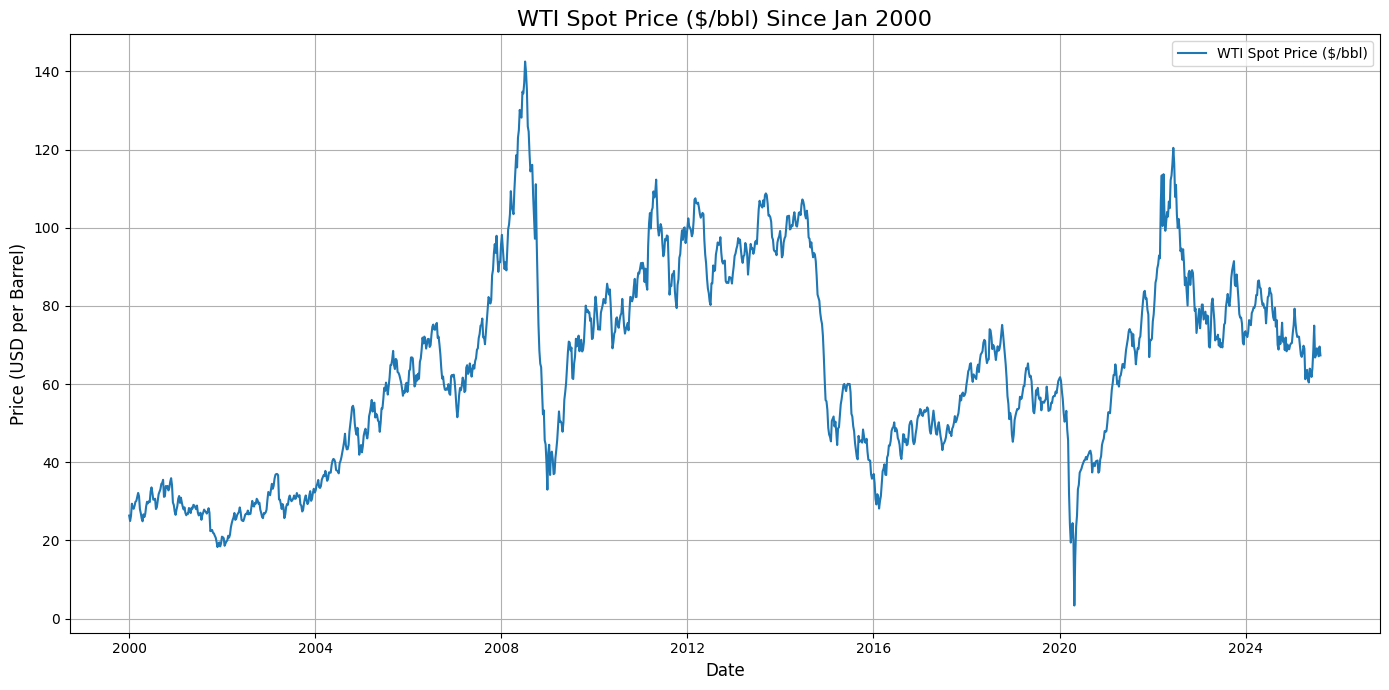

In [144]:
# WTI only — from Jan 2000 onward
start = pd.Timestamp("2000-01-01")
wp = weekly_prices.sort_index()
wp_2000 = wp.loc[wp.index >= start]

plt.figure(figsize=(14, 7))
plt.plot(wp_2000.index, wp_2000["wti_spot_usd_bbl"], label="WTI Spot Price ($/bbl)")
plt.title("WTI Spot Price ($/bbl) Since Jan 2000", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD per Barrel)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check missing values - Weekly Data

In [21]:
# Check missing values before unifying
weekly_wide.isna().sum()

variable
PADD2_refinery_input_kbd     519
PADD2_refinery_util_prct    1444
PADD3_refinery_input_kbd     519
PADD3_refinery_util_prct    1444
PADD3_stock_kbbl             379
cushing_stock_kbbl          1123
us_crude_exports             436
us_crude_imports             379
us_crude_net_imports         997
us_pro_exports               437
us_pro_imports               379
us_pro_net_imports           997
us_product_supply            424
us_refinery_input_kbd          0
us_refinery_util_prct        422
us_stock_kbbl                379
dtype: int64

Most of the missing value are older series that were not collected back in the days or EIA changed the methodology.

The next cleaning process will be cutting off the data serie


In [22]:
weekly_wide.head()

variable    PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
date                                                             
1982-08-22                       NaN                       NaN   
1982-08-29                       NaN                       NaN   
1982-09-26                       NaN                       NaN   
1982-10-03                       NaN                       NaN   
1982-10-10                       NaN                       NaN   

variable    PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
date                                                             
1982-08-22                       NaN                       NaN   
1982-08-29                       NaN                       NaN   
1982-09-26                       NaN                       NaN   
1982-10-03                       NaN                       NaN   
1982-10-10                       NaN                       NaN   

variable    PADD3_stock_kbbl  cushing_stock_kbbl  us_crude_exports  \
date                                                                 
1982-08-22               NaN                 NaN               NaN   
1982-08-29               NaN                 NaN               NaN   
1982-09-26               NaN                 NaN               NaN   
1982-10-03               NaN                 NaN               NaN   
1982-10-10               NaN                 NaN               NaN   

variable    us_crude_imports  us_crude_net_imports  us_pro_exports  \
date                                                                 
1982-08-22               NaN                   NaN             NaN   
1982-08-29               NaN                   NaN             NaN   
1982-09-26               NaN                   NaN             NaN   
1982-10-03               NaN                   NaN             NaN   
1982-10-10               NaN                   NaN             NaN   

variable    us_pro_imports  us_pro_net_imports  us_product_supply  \
date                                                                
1982-08-22             NaN                 NaN                NaN   
1982-08-29             NaN                 NaN                NaN   
1982-09-26             NaN                 NaN                NaN   
1982-10-03             NaN                 NaN                NaN   
1982-10-10             NaN                 NaN                NaN   

variable    us_refinery_input_kbd  us_refinery_util_prct  us_stock_kbbl  
date                                                                     
1982-08-22                11722.0                    NaN            NaN  
1982-08-29                11918.0                    NaN            NaN  
1982-09-26                12375.0                    NaN            NaN  
1982-10-03                12303.0                    NaN            NaN  
1982-10-10                12062.0                    NaN            NaN

**Justification: Cutting off**

A 14-year period provides a robust and representative sample for capturing medium- to long-term market trends, offering enough observations for meaningful statistical analysis while avoiding excessive historical noise.

Older patterns—such as the severe landlock of WTI at Cushing in the 2000s, which no longer reflects current operational dynamics—could bias results if included. For higher data completeness, consistency across all variables, and market relevance. Also, most missing values were concentrated in the earliest years of the dataset, with significant gaps in PADD2 and PADD3 refinery utilization before June 2010.

For weekly data, 14 years gives you roughly 730+ observations, which is more than enough to detect seasonal cycles, structural changes, and long-term trends. Energy markets often go through multi-year cycles (e.g., supply shocks, price collapses, infrastructure expansions). Fourteen years usually covers several complete market cycles, making the analysis more robust.

The analysis was restricted to June 2010–August 2025. This cutoff minimizes data gaps, aligns all time series to a common coverage period, and ensures the dataset reflects modern market behavior.

In [23]:
# Set cutoff
CUTOFF = pd.Timestamp("2010-06-01")

weekly_wide_cut  = weekly_wide.loc[weekly_wide.index  >= CUTOFF].copy()
monthly_wide_cut = daily_prod.loc[daily_prod.index >= CUTOFF].copy()
daily_wide_cut   = weekly_prices.loc[weekly_prices.index   >= CUTOFF].copy()

print("Shapes after cutoff (>= 2010-06-01):")
print("weekly_wide_cut :", weekly_wide_cut.shape)
print("monthly_wide_cut:", monthly_wide_cut.shape)
print("daily_wide_cut  :", daily_wide_cut.shape)

# Recheck missing values (counts)
for name, df in {
    "weekly_wide_cut": weekly_wide_cut,
    "monthly_wide_cut": monthly_wide_cut,
    "daily_wide_cut": daily_wide_cut
}.items():
    print(f"\n{name} — missing values:")
    print(df.isna().sum().sort_values(ascending=False))

Shapes after cutoff (>= 2010-06-01):
weekly_wide_cut : (792, 16)
monthly_wide_cut: (5479, 1)
daily_wide_cut  : (793, 2)

weekly_wide_cut — missing values:
variable
PADD2_refinery_input_kbd    0
PADD2_refinery_util_prct    0
PADD3_refinery_input_kbd    0
PADD3_refinery_util_prct    0
PADD3_stock_kbbl            0
cushing_stock_kbbl          0
us_crude_exports            0
us_crude_imports            0
us_crude_net_imports        0
us_pro_exports              0
us_pro_imports              0
us_pro_net_imports          0
us_product_supply           0
us_refinery_input_kbd       0
us_refinery_util_prct       0
us_stock_kbbl               0
dtype: int64

monthly_wide_cut — missing values:
variable
us_crude_field_product_kbd    0
dtype: int64

daily_wide_cut — missing values:
variable
brent_spot_usd_bbl    0
wti_spot_usd_bbl      0
dtype: int64


# Creating a new df with all the data

In [24]:
weekly_all = (
    weekly_wide_cut
    .join(weekly_prices, how="left")
    .join(weekly_prod_total, how="left")
)

# Find latest date where ALL series have data (non-NaN)
common_end = weekly_all.dropna(how="any").index.max()

# Trim the merged DataFrame
weekly_all = weekly_all.loc[:common_end]

print("Final shape:", weekly_all.shape)
print("Last date in final dataset:", weekly_all.index.max())
print(weekly_all.tail())

Final shape: (783, 19)
Last date in final dataset: 2025-06-01 00:00:00
variable    PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
date                                                             
2025-05-04                    3697.0                      88.8   
2025-05-11                    3874.0                      91.8   
2025-05-18                    3882.0                      91.5   
2025-05-25                    3859.0                      91.0   
2025-06-01                    3992.0                      94.0   

variable    PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
date                                                             
2025-05-04                    9146.0                      92.5   
2025-05-11                    9287.0                      93.3   
2025-05-18                    9201.0                      92.4   
2025-05-25                    9160.0                      92.6   
2025-06-01                    9467.0                      95.5   

var

In [25]:
df.isna().sum()

variable
brent_spot_usd_bbl    0
wti_spot_usd_bbl      0
dtype: int64

To ensure all variables remain perfectly aligned, we merged all weekly datasets first and then applied a single cutoff to the combined table. This approach prevents inconsistencies that could arise from trimming each dataset separately.

By identifying the latest week with complete data across all variables (dropna(how="any")), we guaranteed that the final analysis period contains no missing values. This method also simplifies documentation, as the report can clearly state: “All weekly datasets were merged and then trimmed to the latest week with complete data across all variables.”

# Exploratory Data Analysis (EDA)

In [26]:
df = weekly_all.copy()

In [27]:
# Explore head of the full df
df.head()

variable    PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
date                                                             
2010-06-06                    3396.0                      92.4   
2010-06-13                    3363.0                      90.9   
2010-06-20                    3461.0                      93.5   
2010-06-27                    3391.0                      92.2   
2010-07-04                    3431.0                      93.8   

variable    PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
date                                                             
2010-06-06                    7646.0                      92.0   
2010-06-13                    7684.0                      91.3   
2010-06-20                    7506.0                      90.8   
2010-06-27                    7439.0                      88.8   
2010-07-04                    7439.0                      89.0   

variable    PADD3_stock_kbbl  cushing_stock_kbbl  us_crude_exports  \
date                                                                 
2010-06-06          162294.0             37416.0              34.0   
2010-06-13          162546.0             37610.0              34.0   
2010-06-20          164648.0             36784.0              33.0   
2010-06-27          167146.0             35989.0              33.0   
2010-07-04          166268.0             35805.0              33.0   

variable    us_crude_imports  us_crude_net_imports  us_pro_exports  \
date                                                                 
2010-06-06            9535.0                9501.0          1751.0   
2010-06-13            9699.0                9665.0          1751.0   
2010-06-20           10112.0               10079.0          1992.0   
2010-06-27            9481.0                9448.0          1992.0   
2010-07-04            9413.0                9380.0          1992.0   

variable    us_pro_imports  us_pro_net_imports  us_product_supply  \
date                                                                
2010-06-06          2015.0               264.0            19316.0   
2010-06-13          2107.0               356.0            19135.0   
2010-06-20          2324.0               332.0            19498.0   
2010-06-27          2614.0               622.0            18967.0   
2010-07-04          3027.0              1035.0            19599.0   

variable    us_refinery_input_kbd  us_refinery_util_prct  us_stock_kbbl  \
date                                                                      
2010-06-06                15187.0                   89.1      1069938.0   
2010-06-13                15114.0                   87.9      1074374.0   
2010-06-20                15191.0                   89.4      1077053.0   
2010-06-27                15093.0                   88.4      1080628.0   
2010-07-04                15228.0                   89.8      1080907.0   

variable    brent_spot_usd_bbl  wti_spot_usd_bbl  us_crude_field_product_kbd  
date                                                                          
2010-06-06              72.705           72.9075                      1254.0  
2010-06-13              72.762           73.4360                      1260.0  
2010-06-20              76.218           76.7000                      1260.0  
2010-06-27              76.642           77.0600                      1260.0  
2010-07-04              73.858           74.9580                      1234.0

In [28]:
# List of columns
sorted(df.columns.tolist())

['PADD2_refinery_input_kbd',
 'PADD2_refinery_util_prct',
 'PADD3_refinery_input_kbd',
 'PADD3_refinery_util_prct',
 'PADD3_stock_kbbl',
 'brent_spot_usd_bbl',
 'cushing_stock_kbbl',
 'us_crude_exports',
 'us_crude_field_product_kbd',
 'us_crude_imports',
 'us_crude_net_imports',
 'us_pro_exports',
 'us_pro_imports',
 'us_pro_net_imports',
 'us_product_supply',
 'us_refinery_input_kbd',
 'us_refinery_util_prct',
 'us_stock_kbbl',
 'wti_spot_usd_bbl']

In [29]:
df.shape

(783, 19)

In [30]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2010-06-06 to 2025-06-01
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PADD2_refinery_input_kbd    783 non-null    float64
 1   PADD2_refinery_util_prct    783 non-null    float64
 2   PADD3_refinery_input_kbd    783 non-null    float64
 3   PADD3_refinery_util_prct    783 non-null    float64
 4   PADD3_stock_kbbl            783 non-null    float64
 5   cushing_stock_kbbl          783 non-null    float64
 6   us_crude_exports            783 non-null    float64
 7   us_crude_imports            783 non-null    float64
 8   us_crude_net_imports        783 non-null    float64
 9   us_pro_exports              783 non-null    float64
 10  us_pro_imports              783 non-null    float64
 11  us_pro_net_imports          783 non-null    float64
 12  us_product_supply           783 non-null    float64
 13  us_refinery_inpu

In [31]:
# Describe with basic statistic
df.describe()

variable  PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
count                   783.000000                783.000000   
mean                   3625.849298                 91.047510   
std                     264.674650                  5.488685   
min                    2717.000000                 65.000000   
25%                    3461.500000                 87.750000   
50%                    3617.000000                 92.000000   
75%                    3821.000000                 94.800000   
max                    4242.000000                101.700000   

variable  PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
count                   783.000000                783.000000   
mean                   8318.833972                 89.998595   
std                     702.429633                  5.951890   
min                    3894.000000                 40.900000   
25%                    7858.500000                 87.400000   
50%                    8433.000000                 91.100000   
75%                    8849.000000                 94.100000   
max                    9649.000000                 99.700000   

variable  PADD3_stock_kbbl  cushing_stock_kbbl  us_crude_exports  \
count           783.000000          783.000000        783.000000   
mean         216937.298851        41022.424010       1781.623244   
std           40744.625587        13465.913408       1656.867394   
min          131999.000000        17899.000000         32.000000   
25%          172840.000000        30724.000000         64.000000   
50%          228329.000000        38570.000000       1310.000000   
75%          247700.500000        50621.500000       3259.000000   
max          309016.000000        69420.000000       5629.000000   

variable  us_crude_imports  us_crude_net_imports  us_pro_exports  \
count           783.000000            783.000000      783.000000   
mean           7320.118774           5538.494253     4497.648787   
std            1085.622183           2554.247320     1417.990334   
min            4599.000000            579.000000     1751.000000   
25%            6455.000000           3047.500000     3344.500000   
50%            7341.000000           6401.000000     4629.000000   
75%            8042.000000           7674.500000     5591.000000   
max           11153.000000          11120.000000     7617.000000   

variable  us_pro_imports  us_pro_net_imports  us_product_supply  \
count         783.000000          783.000000         783.000000   
mean         2079.328225        -2418.320562       19737.353768   
std           354.255833         1526.482185        1152.280850   
min          1182.000000        -6289.000000       13797.000000   
25%          1839.000000        -3560.500000       19040.500000   
50%          2059.000000        -2433.000000       19696.000000   
75%          2294.000000        -1309.500000       20523.500000   
max          3118.000000         1035.000000       23191.000000   

variable  us_refinery_input_kbd  us_refinery_util_prct  us_stock_kbbl  \
count                783.000000             783.000000   7.830000e+02   
mean               15729.498084              88.689655   1.204271e+06   
std                 1020.923990               5.100089   1.088049e+05   
min                 9903.000000              56.000000   1.001111e+06   
25%                15102.500000              86.300000   1.094047e+06   
50%                15831.000000              89.400000   1.227228e+06   
75%                16442.000000              92.300000   1.280090e+06   
max                17981.000000              98.100000   1.461620e+06   

variable  brent_spot_usd_bbl  wti_spot_usd_bbl  us_crude_field_product_kbd  
count             783.000000        783.000000                  783.000000  
mean               77.952874         71.737864                 2272.928480  
std                24.815965         21.389215                  575.725482  
min                14.236000          3.324000    

The summary statistics show large differences in scale among variables (e.g., refinery inputs vs. utilization percentages). These scale differences will be addressed in the preprocessing phase to ensure fair weighting in model training.

In [32]:
# How many NaN
df.isnull().sum()

variable
PADD2_refinery_input_kbd      0
PADD2_refinery_util_prct      0
PADD3_refinery_input_kbd      0
PADD3_refinery_util_prct      0
PADD3_stock_kbbl              0
cushing_stock_kbbl            0
us_crude_exports              0
us_crude_imports              0
us_crude_net_imports          0
us_pro_exports                0
us_pro_imports                0
us_pro_net_imports            0
us_product_supply             0
us_refinery_input_kbd         0
us_refinery_util_prct         0
us_stock_kbbl                 0
brent_spot_usd_bbl            0
wti_spot_usd_bbl              0
us_crude_field_product_kbd    0
dtype: int64

### Data Overview

Period covered: June 2010 – June 2025 (783 weekly observations).

Variables: 19 continuous numeric columns covering refinery inputs/utilization, stocks, imports/exports, product supply, crude oil prices, and production.

Completeness: No missing values after handling; all series are now complete and aligned.

Scale: Variables range from small volumes (kbd exports) to large stock levels (>1 million kbbl) and prices in USD/bbl.

In [33]:
# Correlaion Matrix
df.corr()

variable                    PADD2_refinery_input_kbd  \
variable                                               
PADD2_refinery_input_kbd                    1.000000   
PADD2_refinery_util_prct                    0.730232   
PADD3_refinery_input_kbd                    0.612795   
PADD3_refinery_util_prct                    0.377195   
PADD3_stock_kbbl                            0.400357   
cushing_stock_kbbl                         -0.190713   
us_crude_exports                            0.500655   
us_crude_imports                           -0.275781   
us_crude_net_imports                       -0.441975   
us_pro_exports                              0.588610   
us_pro_imports                              0.000209   
us_pro_net_imports                         -0.546727   
us_product_supply                           0.556596   
us_refinery_input_kbd                       0.670352   
us_refinery_util_prct                       0.586245   
us_stock_kbbl                               0.353858   
brent_spot_usd_bbl                         -0.149685   
wti_spot_usd_bbl                           -0.105149   
us_crude_field_product_kbd                  0.568505   

variable                    PADD2_refinery_util_prct  \
variable                                               
PADD2_refinery_input_kbd                    0.730232   
PADD2_refinery_util_prct                    1.000000   
PADD3_refinery_input_kbd                    0.323253   
PADD3_refinery_util_prct                    0.439551   
PADD3_stock_kbbl                           -0.195637   
cushing_stock_kbbl                         -0.068862   
us_crude_exports                           -0.153043   
us_crude_imports                            0.302442   
us_crude_net_imports                        0.227820   
us_pro_exports                             -0.054323   
us_pro_imports                              0.082590   
us_pro_net_imports                          0.069629   
us_product_supply                           0.360206   
us_refinery_input_kbd                       0.592914   
us_refinery_util_prct                       0.673487   
us_stock_kbbl                              -0.145046   
brent_spot_usd_bbl                          0.126287   
wti_spot_usd_bbl                            0.132771   
us_crude_field_product_kbd                 -0.093586   

variable                    PADD3_refinery_input_kbd  \
variable                                               
PADD2_refinery_input_kbd                    0.612795   
PADD2_refinery_util_prct                    0.323253   
PADD3_refinery_input_kbd                    1.000000   
PADD3_refinery_util_prct                    0.821904   
PADD3_stock_kbbl                            0.396783   
cushing_stock_kbbl                         -0.092797   
us_crude_exports                            0.399852   
us_crude_imports                           -0.186199   
us_crude_net_imports                       -0.338512   
us_pro_exports                              0.596433   
us_pro_imports                             -0.092193   
us_pro_net_imports                         -0.575438   
us_product_supply                           0.540666   
us_refinery_input_kbd                       0.913954   
us_refinery_util_prct                       0.797148   
us_stock_kbbl                               0.368073   
brent_spot_usd_bbl                         -0.254786   
wti_spot_usd_bbl                           -0.213043   
us_crude_field_product_kbd                  0.552995   

variable                    PADD3_refinery_util_prct  PADD3_stock_kbbl  \
variable                                                                 
PADD2_refinery_input_kbd                    0.377195          0.400357   
PADD2_refinery_util_prct                    0.439551         -0.195637   
PADD3_refinery_input_kbd                    0.821904          0.396783   
PADD3_refinery_util_prct                    1.000000         -0.091060   
PADD3_stock_kbbl         

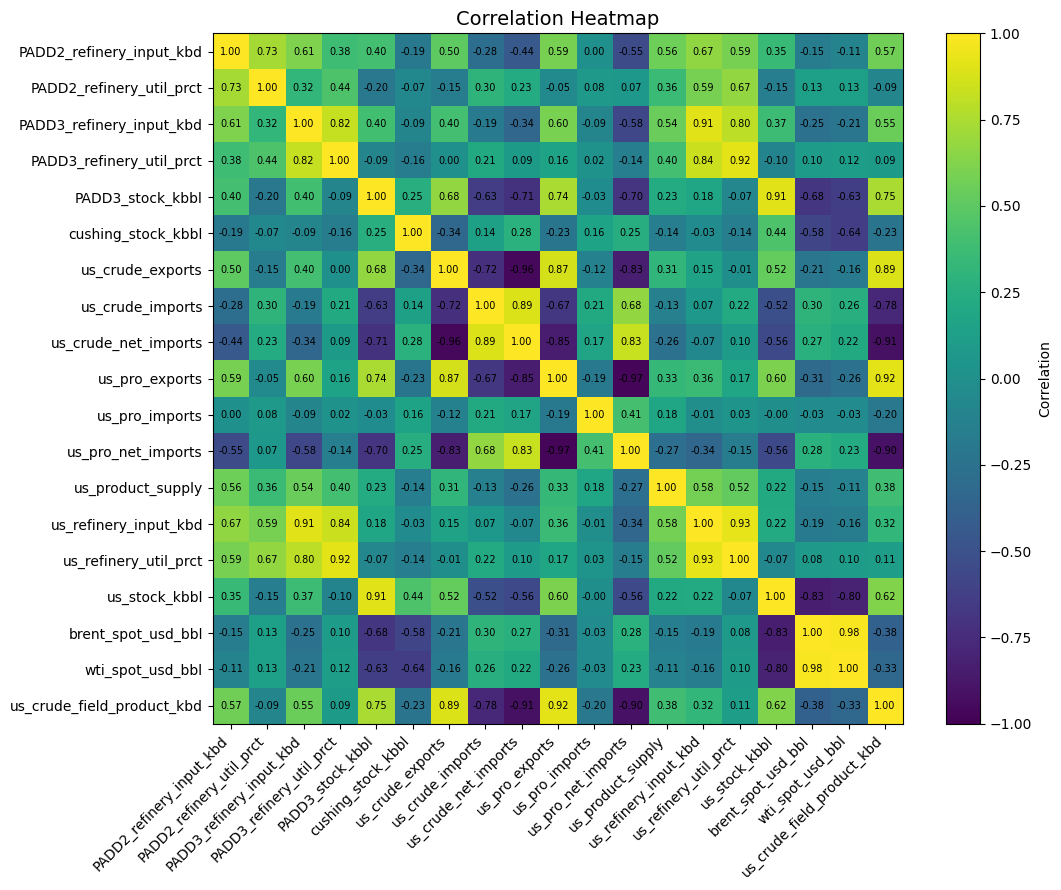

In [34]:
corr = df.corr(numeric_only=True)

# Heatmap
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

# Ticks & labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', rotation=90)

# Cells with values
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i, j]:.2f}",
                ha='center', va='center', fontsize=7)

plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

### Correlations & Relationships

Refinery input & utilization: Strong positive correlation (US: 0.93).

Stocks vs. prices: Strong negative correlation (Brent: –0.83, WTI: –0.80) — higher inventories tend to coincide with lower prices.

Crude exports & production: Very strong positive correlation (0.89).

Imports & exports: Strong negative relationship, reflecting trade balance shifts.

### Collinearity

The correlation heatmap clearly confirms the expected collinearity between U.S. totals and regional series (PADD2, PADD3, and Cushing). For example, U.S. refinery input is almost perfectly correlated with PADD2 and PADD3 inputs, while U.S. crude stocks move closely with both Cushing and PADD3 stocks. This is intuitive since national aggregates are essentially the sum of the regional data and PADD3 is the #1 contribution, but it introduces redundancy in modeling.

With correlations often exceeding ρ > 0.9, multicollinearity is a serious risk if left unaddressed. Including highly overlapping features in an OLS regression would inflate variance and obscure driver importance. This reinforces the need for regularization methods (Lasso/Ridge) or careful feature pruning within the pipeline to stabilize estimates and allow the model to surface the most relevant signals without being distorted by duplicative inputs.

## Correlation Insights — WTI Spot Price

### Strong Positive Correlation

brent_spot_usd_bbl: 0.99 — Virtually perfect correlation with Brent prices, confirming they move almost identically in global markets.

us_crude_field_product_kbd: ~0.58 — Higher US crude production tends to coincide with higher WTI prices, though not perfectly (likely influenced by global supply-demand balance and geopolitical events).

### Moderate Positive Correlation

us_product_supply: ~0.38 — Suggests that higher oil product demand often aligns with higher WTI prices, possibly reflecting strong economic activity.

us_refinery_input_kbd: ~0.38 — Indicates that higher refinery runs correlate moderately with higher crude prices.

### Negative Correlation (Inventory Effect)

us_stock_kbbl: –0.38 — Larger US crude inventories are associated with lower WTI prices, consistent with supply-overhang pressure.

PADD3_stock_kbbl: ~–0.25 — Gulf Coast stock levels also have a negative price relationship, but weaker than total US stocks.

cushing_stock_kbbl: ~–0.26 — Higher Cushing stocks tend to depress WTI prices due to it being the delivery point for WTI contracts.

### Negative Correlation with Imports

us_crude_imports: ~–0.33 — Higher crude imports tend to coincide with weaker WTI prices.

us_crude_net_imports: ~–0.38 — Net import dependency negatively correlates with prices.



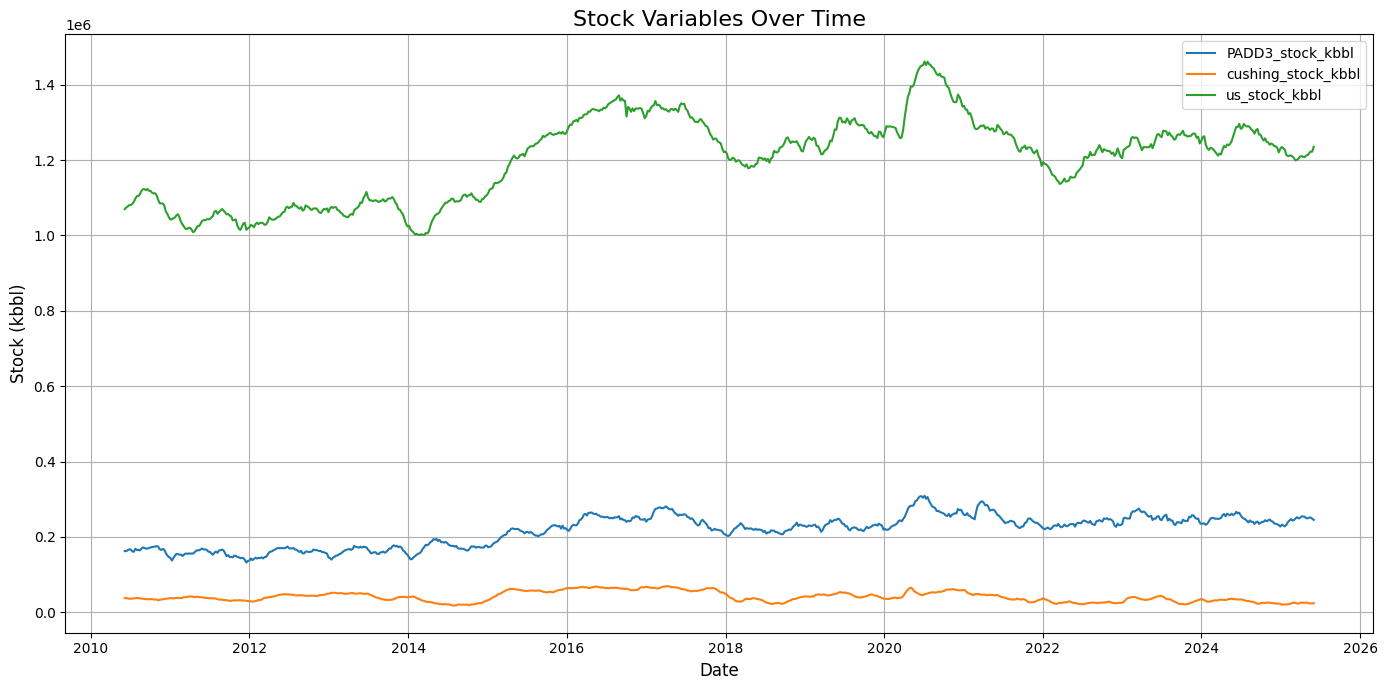

In [35]:
# Stock Market Plot

# Stock-related columns
stock_cols = [col for col in df.columns if "stock" in col.lower()]

# Plot each stock variable
plt.figure(figsize=(14, 7))
for col in stock_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Stock Variables Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock (kbbl)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Stocks (Inventories)

US total crude stocks generally range 1.1–1.3 million kbbl, peaking near 1.46 million kbbl in 2020 during the COVID demand crash.

This peak is notable but not extreme enough to treat as a statistical outlier in the dataset.

Cushing stocks (price benchmark delivery point) are smaller (~20–70k kbbl) and exhibit relatively limited oscillations because the Cushing market is somewhat isolated from broader supply-demand dynamics due to limited crude oil exit capacity, making it less affected by external constraints.

PADD3 stocks trend similarly to total stocks, indicating Gulf Coast storage dominance.

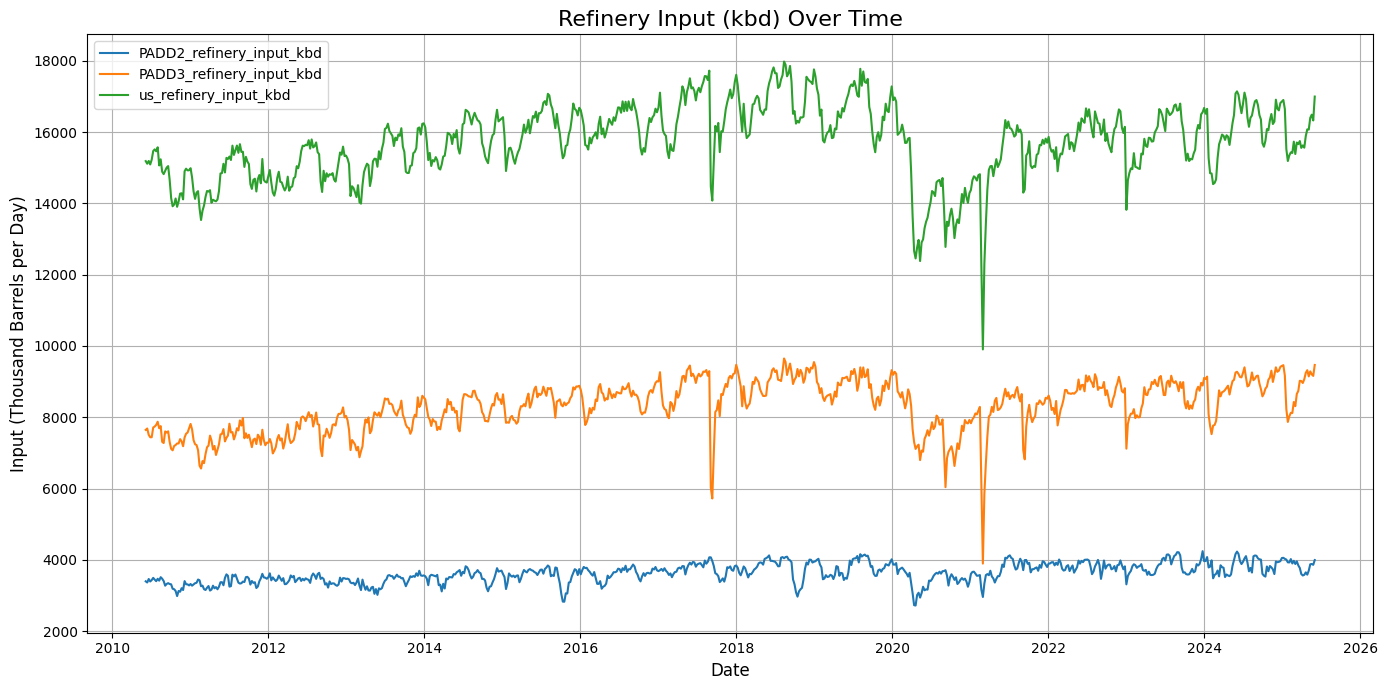

In [36]:
# Refinery Input

input_cols = [col for col in df.columns if "input" in col.lower()]

# Plot each refinery input variable
plt.figure(figsize=(14, 7))
for col in input_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Refinery Input (kbd) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Input (Thousand Barrels per Day)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Refinery Input

US total refinery input fluctuates seasonally, peaking in summer.

PADD3 (Gulf Coast) processes ~2–3× more than PADD2 (Midwest).

Sharp dips correspond to major disruptions: early 2020 (COVID-19 demand collapse), occasional hurricane impacts, the February 2021 winter storm in Texas (utilization ~41%), and a smaller dip in 2017 linked to Hurricane Harvey, which temporarily shut down significant Gulf Coast refining capacity. All were followed by rapid recoveries.

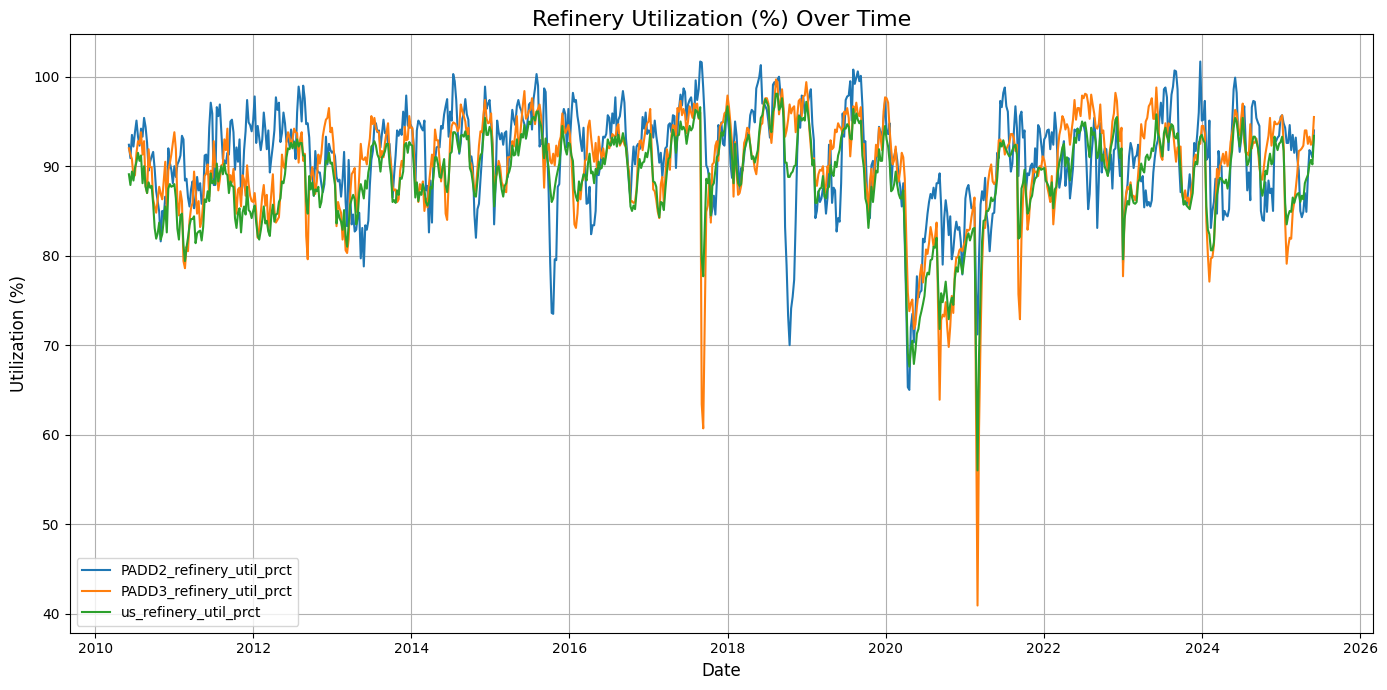

In [37]:
# Percent of Refinery Utilization Plot

# Refinery utilization columns
util_cols = [col for col in df.columns if "util" in col.lower()]

# Plot each refinery utilization variable
plt.figure(figsize=(14, 7))
for col in util_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Refinery Utilization (%) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Utilization (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Utilization Rates

Typically 85–95%, with median around 91% (PADD2) and 90% (PADD3, US).

Outliers down to 40–60% during the major disruption already explained.

Boxplots confirm a tight core distribution with significant low-end outliers during crisis events.

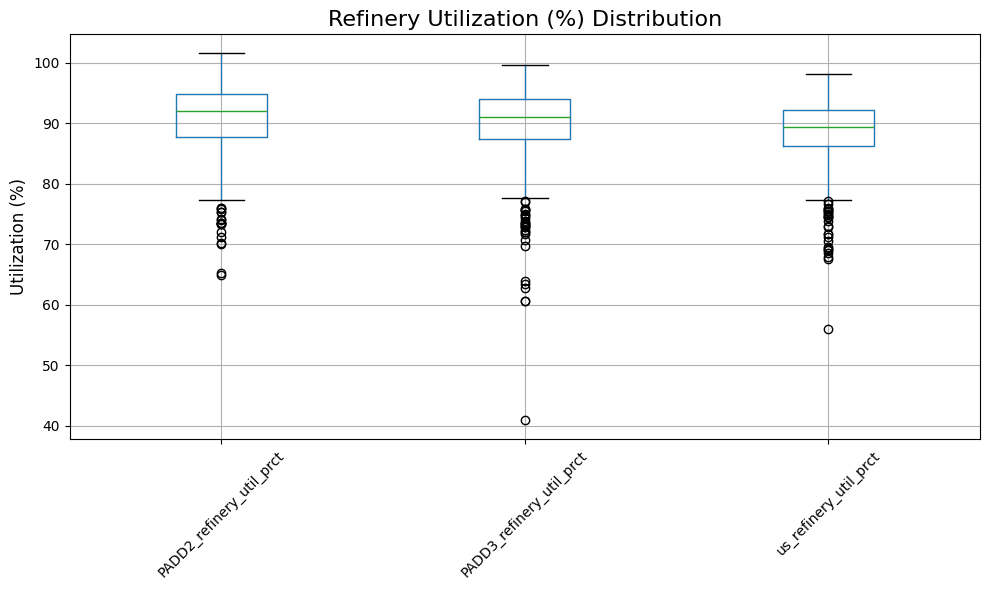

In [38]:
# Box Plot for Refinery Utilization Columns
plt.figure(figsize=(10, 6))
df[util_cols].boxplot()
plt.title("Refinery Utilization (%) Distribution", fontsize=16)
plt.ylabel("Utilization (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Imports & Exports

Crude imports steadily decline from ~9–10 Mbd in 2010 to ~6 Mbd by 2025.

Crude exports remained effectively at zero until late 2015 due to the US crude oil export ban, which was lifted in December 2015. After the ban removal, exports surged to ~4–5 Mbd. The end of the crude oil export ban by 2015 is clearly reflected in the chart. We can also see how USA has become less dependent of crude and product oil imported; the balance is towards export in case of products.

Net crude imports shrink drastically, with the US nearing crude net export status by late 2019–2020.

Product exports (gasoline/diesel) grow steadily; imports remain stable/low, keeping net product imports negative (net exporter).

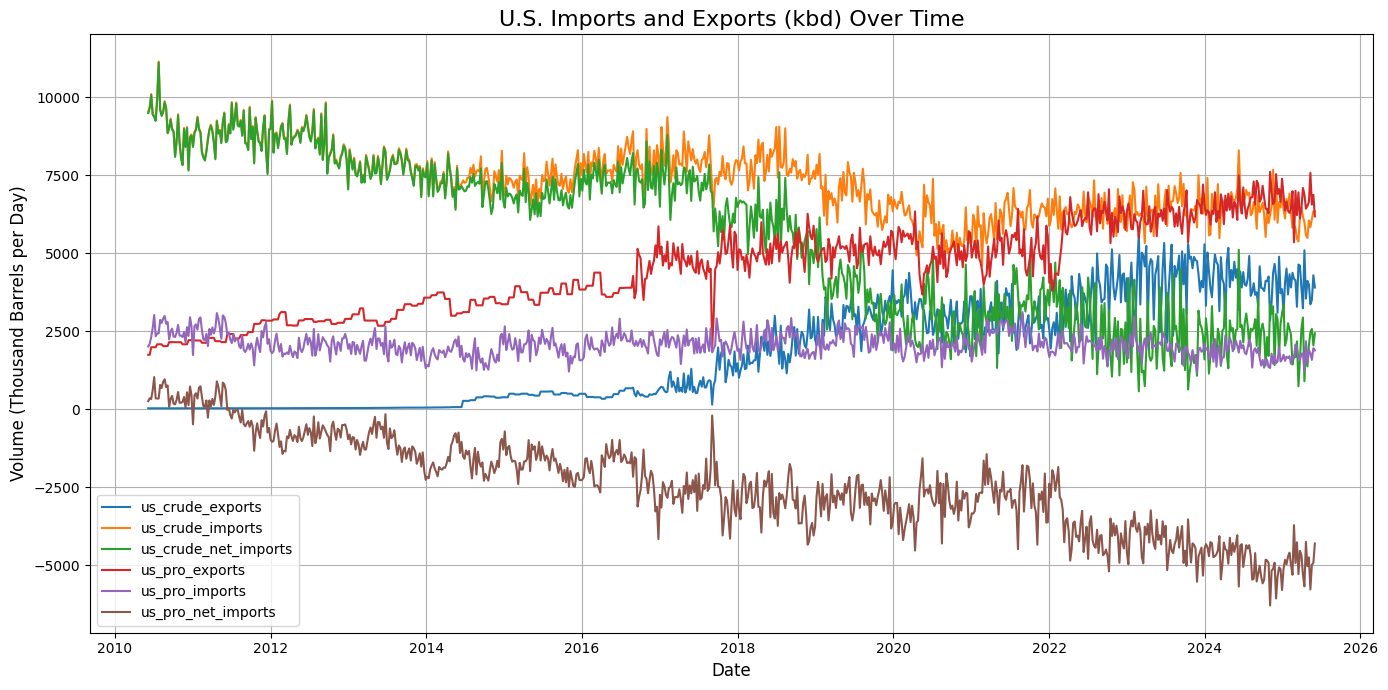

In [39]:
# Crude oil Import and Export visualization

# Select import/export columns
trade_cols = [col for col in df.columns if "import" in col.lower() or "export" in col.lower()]

# Plot each import/export variable
plt.figure(figsize=(14, 7))
for col in trade_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("U.S. Imports and Exports (kbd) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume (Thousand Barrels per Day)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###  Prices (Brent & WTI)

Strong correlation (0.98) between Brent and WTI.

Median: Brent ~USD76/bbl, WTI ~$72/bbl.

Key events:

2011–2014 high price era (> $100/bbl).

2014–2016 oil price collapse (down to ~USD30/bbl).

Apr 2020 crash (WTI weekly average near USD0, with the daily settlement on April 20, 2020, for the May futures contract falling to - USD37.63/bbl — the first time in history prices went negative — due to a storage glut and the contract’s imminent expiry).

2022 price spike (> $120/bbl) after Russia–Ukraine conflict.

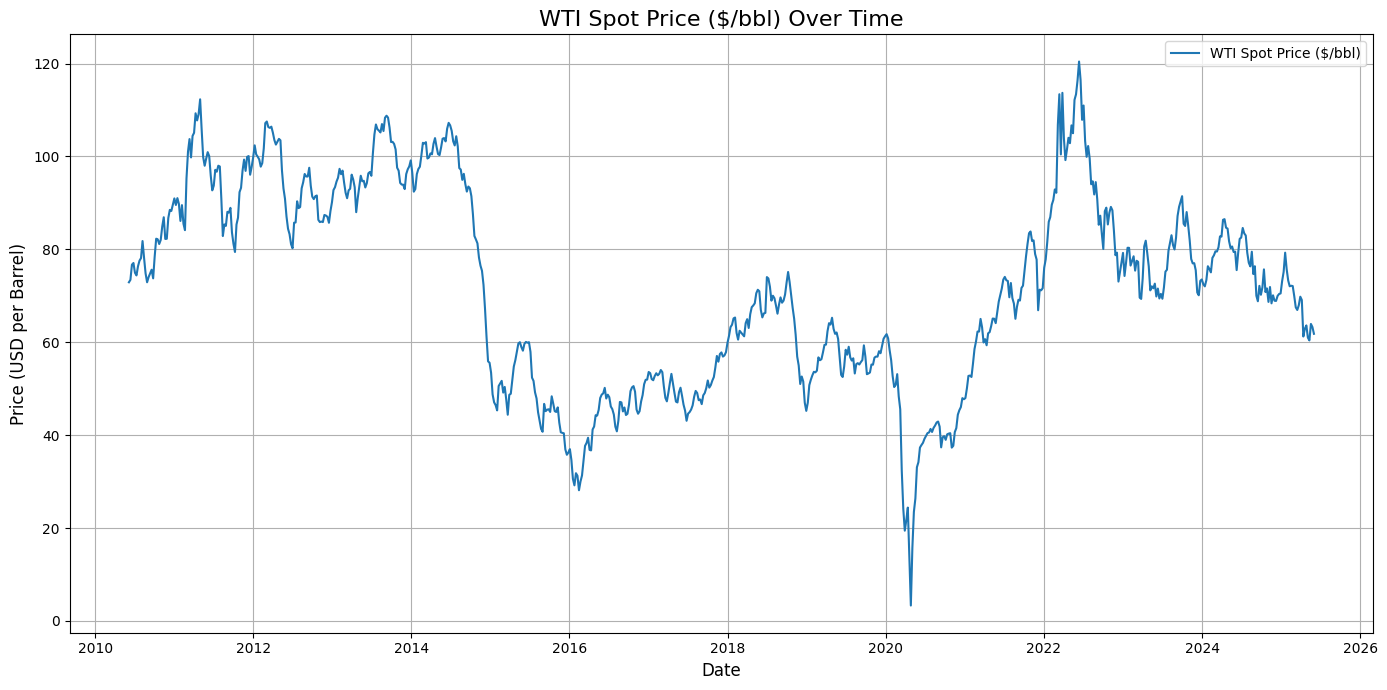

In [143]:
# WTI only
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["wti_spot_usd_bbl"], label="WTI Spot Price ($/bbl)")
plt.title("WTI Spot Price ($/bbl) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD per Barrel)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

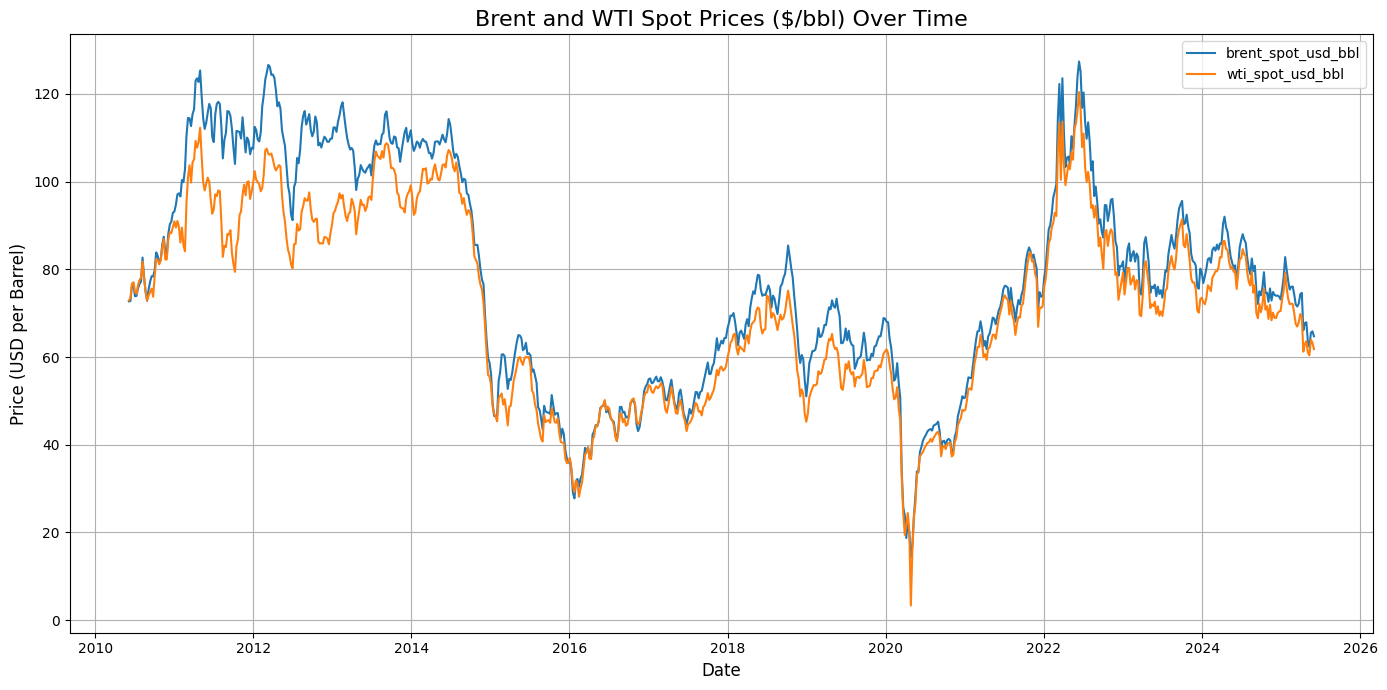

In [40]:
# WTI and Brent prices

# Select price columns (case-insensitive)
price_cols = [col for col in df.columns if "usd_bbl" in col.lower()]

# Plot each price variable
plt.figure(figsize=(14, 7))
for col in price_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Brent and WTI Spot Prices ($/bbl) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD per Barrel)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


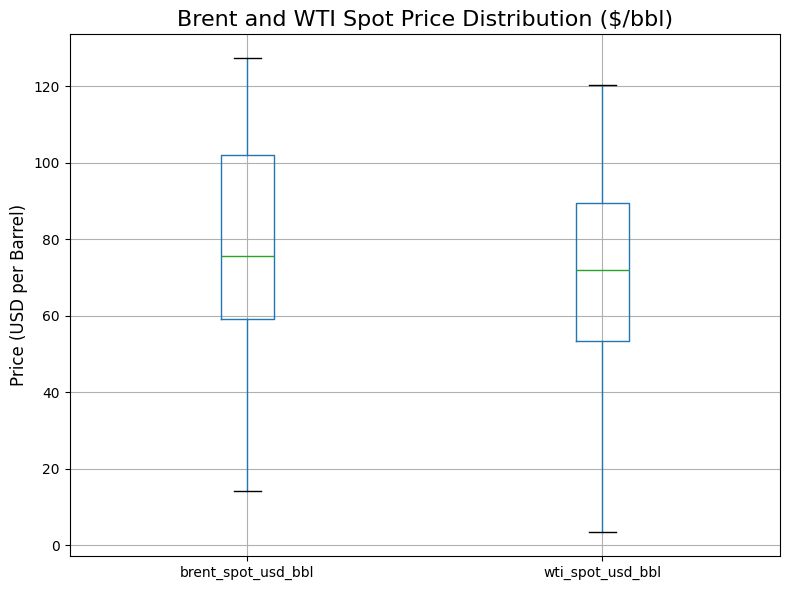

In [41]:
# Box Plot
price_cols = ["brent_spot_usd_bbl", "wti_spot_usd_bbl"]

# Box plot for spot price distributions
plt.figure(figsize=(8, 6))
df[price_cols].boxplot()
plt.title("Brent and WTI Spot Price Distribution ($/bbl)", fontsize=16)
plt.ylabel("Price (USD per Barrel)", fontsize=12)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

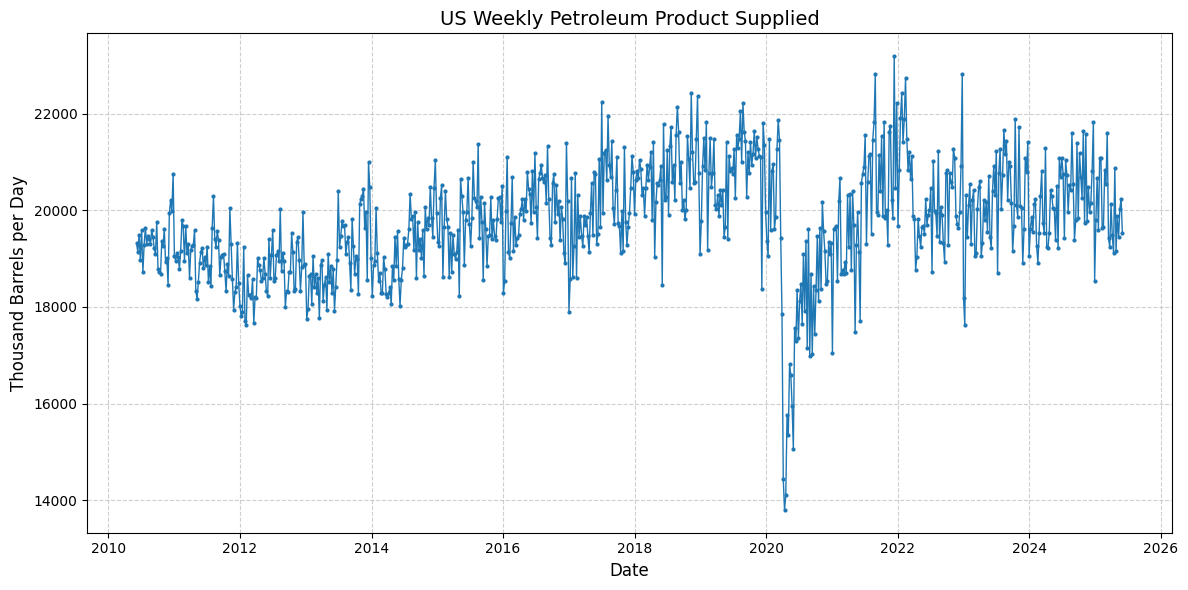

In [42]:
# Product Supply

plt.figure(figsize=(12, 6))
plt.plot(weekly_all.index, weekly_all['us_product_supply'], marker='o', markersize=2, linestyle='-', linewidth=1)
plt.title('US Weekly Petroleum Product Supplied', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Thousand Barrels per Day', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Product Supply (Demand Proxy)

Ranges from 14 to 23 Mbd.

Gradual growth until early 2020, sharp COVID drop (~14 Mbd), then recovery.

Seasonal volatility: higher in summer driving seasons.

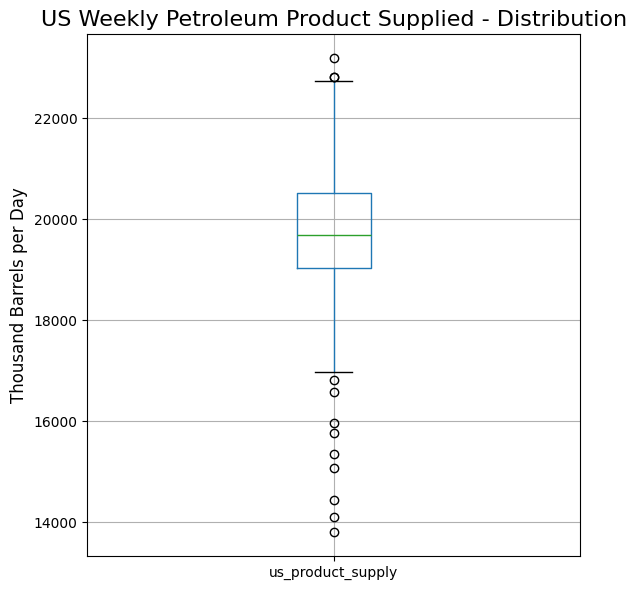

In [43]:
# Box Plot

col = "us_product_supply"  # Replace with your actual column name

# Box plot
plt.figure(figsize=(6, 6))
df[[col]].boxplot()
plt.title("US Weekly Petroleum Product Supplied - Distribution", fontsize=16)
plt.ylabel("Thousand Barrels per Day", fontsize=12)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

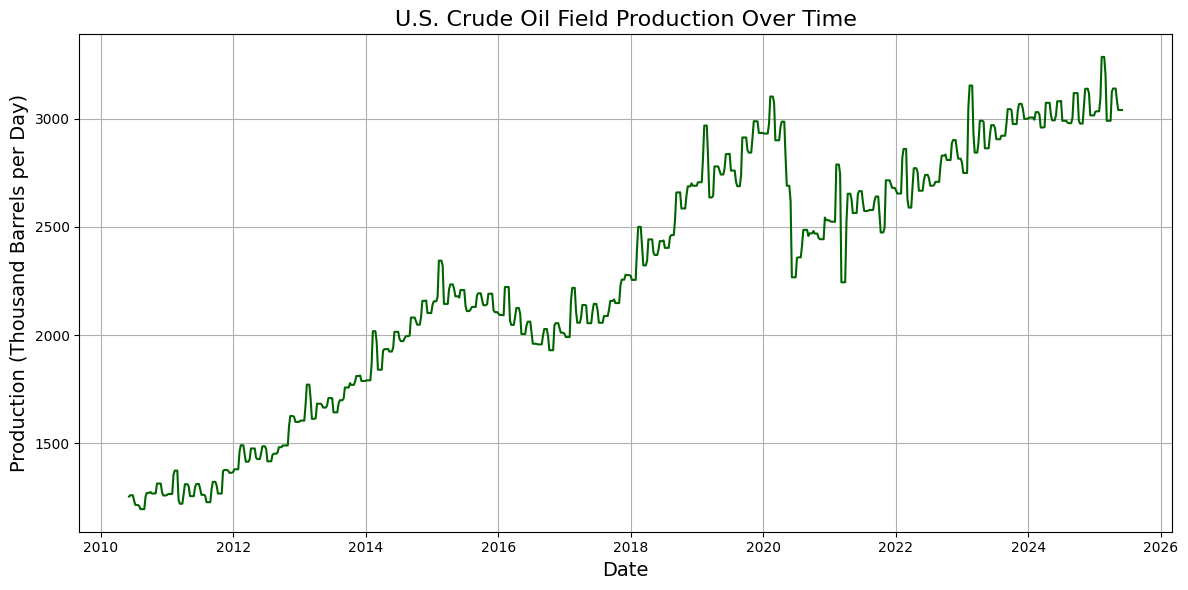

In [44]:
# Plot U.S. crude field production

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['us_crude_field_product_kbd'], color='darkgreen', linewidth=1.5)
plt.title("U.S. Crude Oil Field Production Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Production (Thousand Barrels per Day)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Production

US crude field production rose from ~1.2 Mbd in 2010 to ~3.2 Mbd in 2025.

Growth driven by shale boom (2011–2019), dip in 2020, partial recovery thereafter.

### Key Takeaways

US refining runs and utilization are highly seasonal, resilient but vulnerable to major disruptions.

Stock levels are a leading indicator for price trends — 2020 storage build coincided with record-low prices.

Trade flows shifted fundamentally post-2015, with the US moving toward net crude exports and solidifying product export dominance.

Prices remain globally linked (Brent–WTI), with divergence mainly in short-term market dislocations.

Production growth from shale transformed US market position, reducing import dependency and increasing export capacity.

# Handling Outliers

After the basic statistic and plots, we can proceed to handle outliers when it is needed

## WTI & Brent Spot Prices

We know this April 2020 dip is not representative of real market fundamentals but a technical anomaly from the WTI May-2020 contract expiry and storage crisis due to COVID.

Replacing it with the average of the preceding and following weeks keeps the short-term trend intact while removing an extreme, non-repeatable shock that could distort statistical models.

In [45]:
col = "wti_spot_usd_bbl"
outlier_date = "2020-04-19"  # week of April with the anomaly

# Replace with average of week before and week after
df.loc[outlier_date, col] = (df.loc["2020-04-12", col] + df.loc["2020-04-26", col]) / 2

### Justification

Market microstructure anomaly: The extreme price in April 2020 stems from the May-2020 WTI futures settlement on April 20, 2020, which fell to –$37.63/bbl because of a storage crunch and contract expiry mechanics. The weekly series shows this shock as an aberration relative to adjacent weeks.

Model stability: For time-series modeling of macro relationships (runs, stocks, flows), this single-point distortion can unduly influence coefficients and residual diagnostics. Replacing it with the local linear estimate (midpoint of adjacent weeks) preserves the underlying trend/seasonality while avoiding undue leverage.

Minimal bias, maximum transparency: Only one value is changed, with a full audit record (date, original, neighbors, replacement). Analyses that require the exact historical print (e.g., stress tests) should use the raw series; forecasting/causal modeling can use the cleaned one.

## Refinery Percent of Utilization and Input



In [46]:
# Helper function to replace a single outlier with the average of the previous and next week
def fix_outlier(date_str, col):
    prev_val = df.iloc[df.index.get_loc(date_str) - 1][col]
    next_val = df.iloc[df.index.get_loc(date_str) + 1][col]
    df.loc[date_str, col] = (prev_val + next_val) / 2

# % UTILIZATION outliers --- Known short-lived disruptions:
# - 2017 Hurricane Harvey → US & PADD3
# - 2019 Winter storm → PADD2
# - 2021 Texas winter storm (single week) → US, PADD3, and PADD2

util_events = {
    "us_refinery_util_prct":    ["2017-09-10", "2021-02-28"],
    "PADD3_refinery_util_prct": ["2017-09-10", "2021-02-28"],
    "PADD2_refinery_util_prct": ["2019-02-10", "2021-02-28"],
}

for col, dates in util_events.items():
    for d in dates:
        fix_outlier(d, col)

# --- 2) REFINERY INPUT outliers ---
# Applying the same correction logic for consistency with utilization

input_events = util_events

for col, dates in input_events.items():
    for d in dates:
        fix_outlier(d, col)

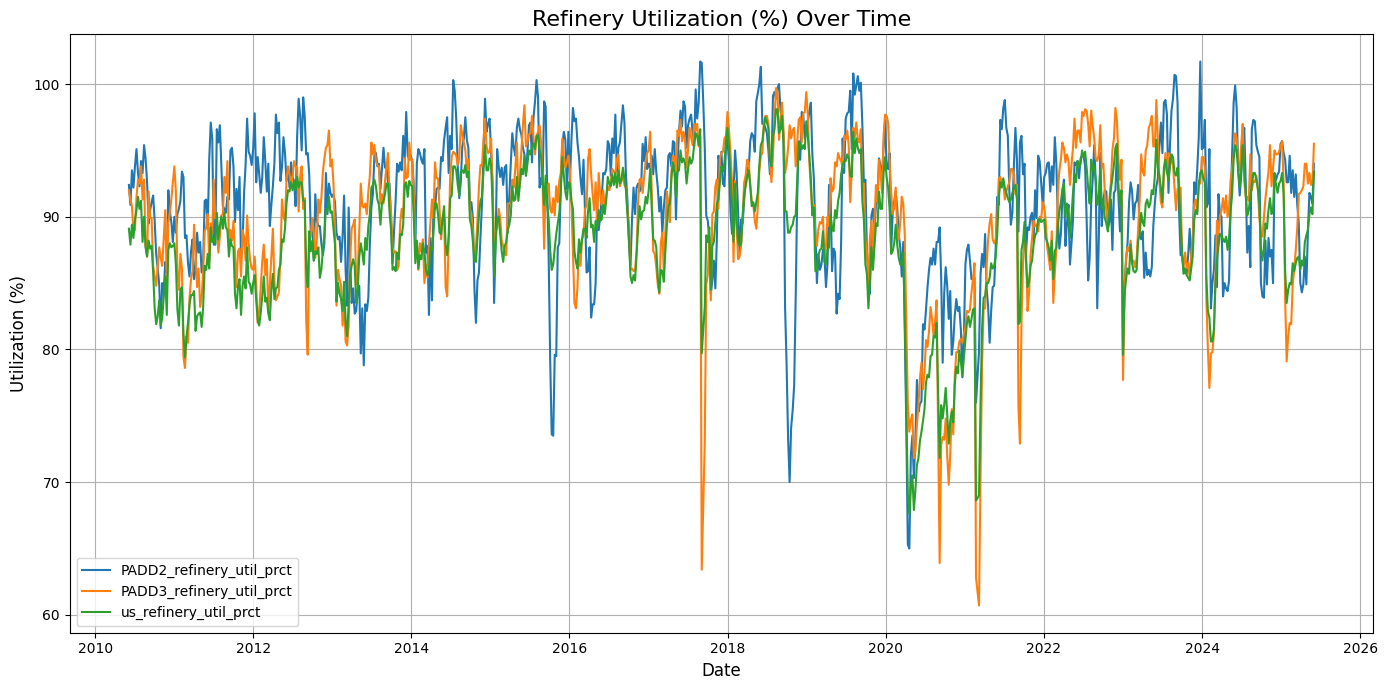

In [47]:
# Percent of Refinery Utilization Plot

# Refinery utilization columns
util_cols = [col for col in df.columns if "util" in col.lower()]

# Plot each refinery utilization variable
plt.figure(figsize=(14, 7))
for col in util_cols:
    plt.plot(df.index, df[col], label=col)

plt.title("Refinery Utilization (%) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Utilization (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Outlier Treatment Summary**

We identified and corrected short-lived refinery utilization and input outliers caused by major disruptions in the U.S. oil industry. The corrections were applied only when the disruption was limited to a single week, so interpolation between the previous and next week provided a reasonable estimate without distorting longer-term patterns.

**Events and Corrections:**

1. Hurricane Harvey (August–September 2017)

   * Affected variables: `us_refinery_util_prct`, `PADD3_refinery_util_prct`, `us_refinery_input_kbd`, `PADD3_refinery_input_kbd`
   * Week corrected: 2017-09-10
   * Rationale: Hurricane Harvey caused an abrupt single-week drop in utilization and input, followed by quick recovery. Values were replaced with the average of the week before and the week after.

2. PADD2 Winter Storm (February 2019)

   * Affected variables: `PADD2_refinery_util_prct`, `PADD2_refinery_input_kbd`
   * Week corrected: 2019-02-10
   * Rationale: Localized severe weather event caused a sharp but short-lived drop.

3. Texas Freeze (February 2021)

   * Affected variables: `us_refinery_util_prct`, `PADD3_refinery_util_prct`, `PADD2_refinery_util_prct`,
     `us_refinery_input_kbd`, `PADD3_refinery_input_kbd`, `PADD2_refinery_input_kbd`
   * Week corrected: 2021-02-28
   * Rationale: Severe winter storm disrupted operations in Texas and surrounding areas for a single week.


**Why We Did Not Correct Certain Variables?**

`us_product_supply`: Outliers were not treated because drops typically lasted 3–4 weeks, making simple week-to-week interpolation inappropriate. These represent sustained operational or demand changes rather than data anomalies.

Other series (e.g., `cushing_stock_kbbl`, crude exports/imports):
  No corrections applied as detected fluctuations aligned with broader market events or persistent shifts, not isolated measurement or operational anomalies.


Justification for Method Interpolation between the previous and next week is valid when the outlier is caused by a short, singular disruption and the surrounding values are stable. Avoided applying the method to multi-week events, where interpolation would artificially smooth real sustained changes.


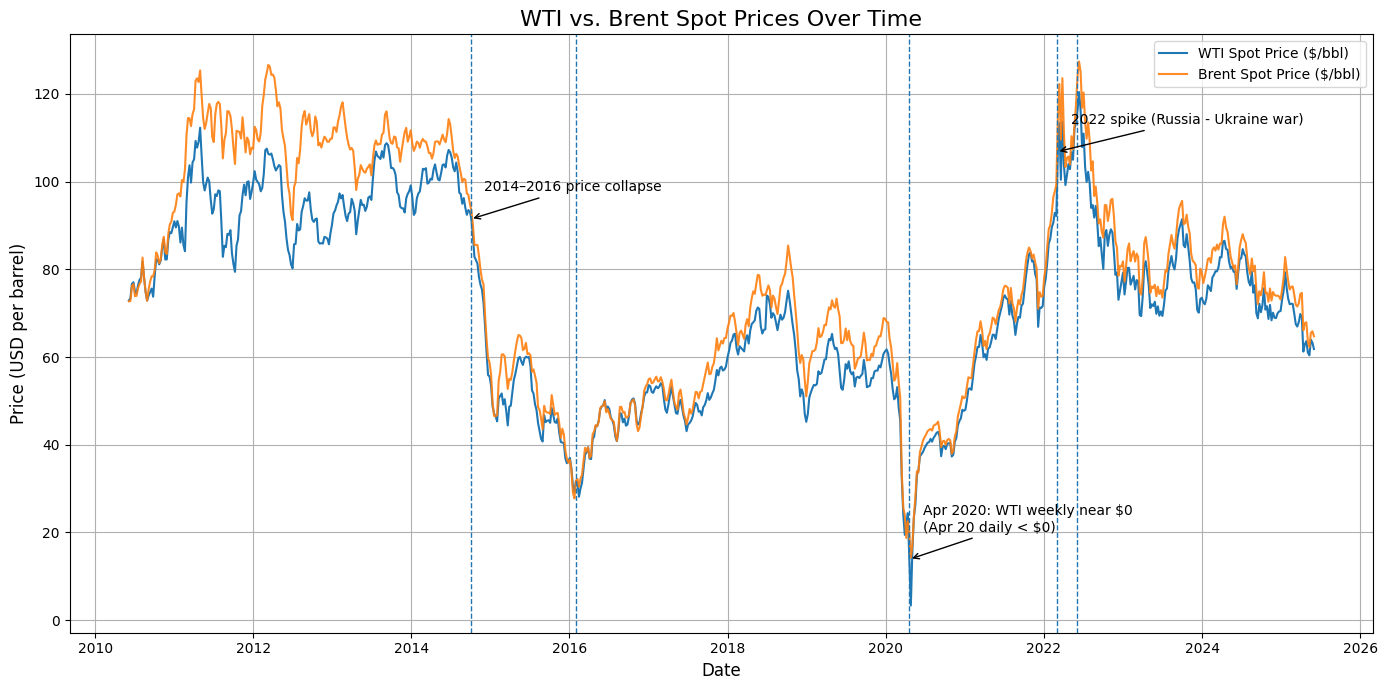

In [48]:
# Plot WTI vs Brent with annotations
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df.index, df['wti_spot_usd_bbl'], label='WTI Spot Price ($/bbl)')
ax.plot(df.index, df['brent_spot_usd_bbl'], label='Brent Spot Price ($/bbl)', alpha=0.9)

# Key event markers (no explicit colors)
events = [
    ("2014-10-01", "2016-02-01", "2014–2016 price collapse"),
    ("2020-04-19", "2020-04-19", "Apr 2020: WTI weekly near $0\n(Apr 20 daily < $0)"),
    ("2022-03-01", "2022-06-01", "2022 spike (Russia - Ukraine war)")
]

for start, end, label in events:
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    # vertical lines at start/end (defaults to matplotlib colors)
    ax.axvline(start_dt, linestyle='--', linewidth=1)
    if end_dt != start_dt:
        ax.axvline(end_dt, linestyle='--', linewidth=1)
    # annotation near start
    ax.annotate(label, xy=(start_dt, df.loc[start_dt:, 'wti_spot_usd_bbl'].iloc[0]),
                xytext=(10, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', linewidth=1))

ax.set_title("WTI vs. Brent Spot Prices Over Time", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price (USD per barrel)", fontsize=12)
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

This chart shows the strong co-movement between WTI and Brent, with Brent typically trading at a modest premium. It highlights notable disruptions—most visibly the April 2020 event when WTI’s weekly average approached USD0 (and the daily print fell below USD0 on April 20), the 2014–2016 oil price collapse, and the 2022 spike associated with geopolitical shocks (wars or conflicts). These episodes are useful reference points for spotting structural breaks and periods of price divergence between the two benchmarks.

**For the purposes of our analysis and scope, the target variable will be the WTI Cushing spot price, as it is the most directly relevant benchmark for U.S. domestic crude market dynamics**

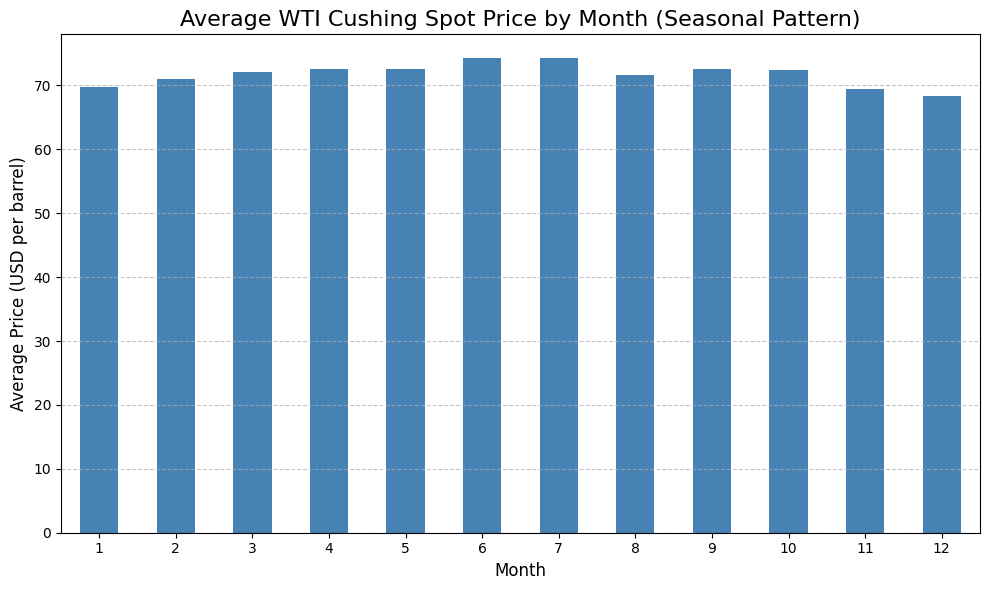

In [49]:
# Seasonal Pattern Analysis

# Extract month from index
df['month'] = df.index.month

# Group by month and calculate average WTI price
monthly_avg_wti = df.groupby('month')['wti_spot_usd_bbl'].mean()

# Plot seasonal pattern
plt.figure(figsize=(10, 6))
monthly_avg_wti.plot(kind='bar', color='steelblue')

plt.title("Average WTI Cushing Spot Price by Month (Seasonal Pattern)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Price (USD per barrel)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The chart shows June–July tends to have the highest average WTI prices, while November–December sees lower averages. This pattern is linked to summer driving season demand in the U.S., increased refinery runs, and global market trends. November–December dips reflect lower demand after summer and hurricane season, as well as year-end inventory adjustments.

The driving season is a seasonal event highly correlated to the gasoline prices, which is one of the 2 main drivers fro the value of the crude oil (The other one are the distillates), so this chart demostrate how that seasonality is trasmitted to the WTI spot prices.

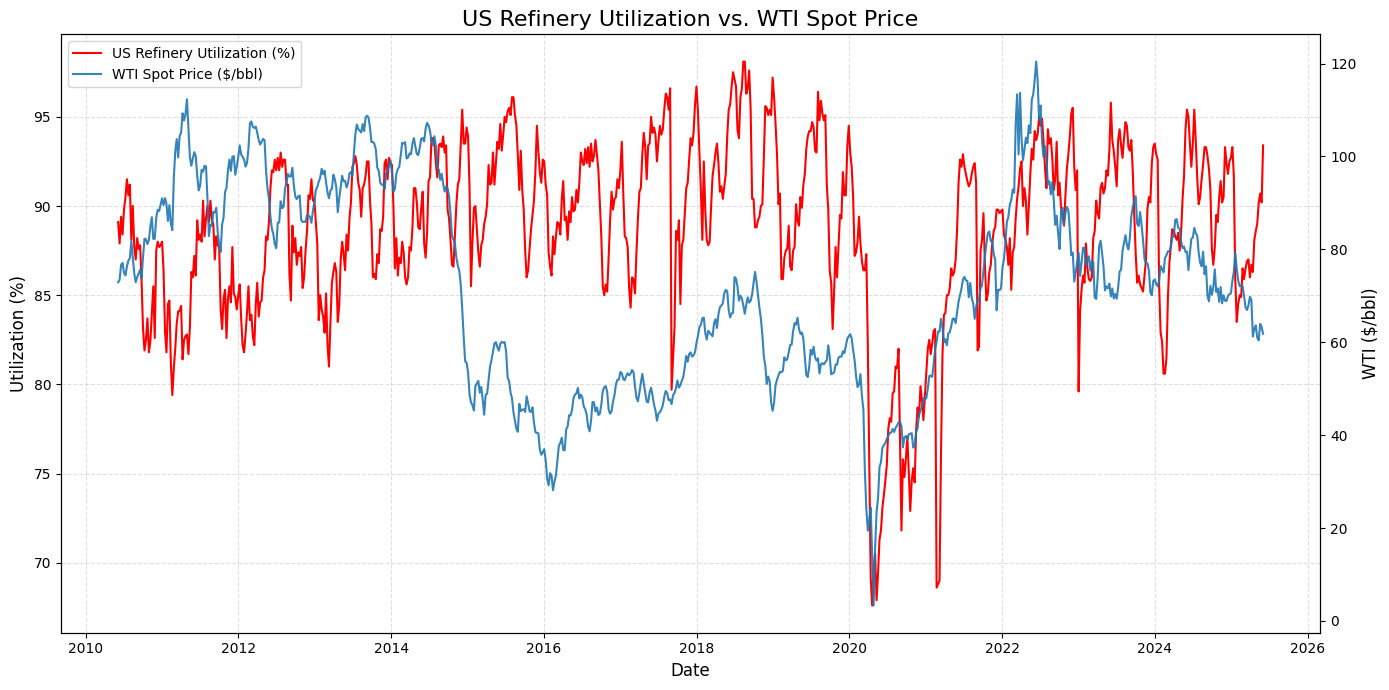

In [50]:
# Refinery Utilization vs. WTI Prices — Demand Signal Analysis

# Columns used
util_col = "us_refinery_util_prct"
wti_col  = "wti_spot_usd_bbl"

fig, ax1 = plt.subplots(figsize=(14, 7))

# Left y-axis: Utilization (%)
ax1.plot(df.index, df[util_col], label="US Refinery Utilization (%)", color='red')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Utilization (%)", fontsize=12)
ax1.grid(True, which="both", axis="both", linestyle="--", alpha=0.4)

# Right y-axis: WTI ($/bbl)
ax2 = ax1.twinx()
ax2.plot(df.index, df[wti_col], label="WTI Spot Price ($/bbl)", alpha=0.9)
ax2.set_ylabel("WTI ($/bbl)", fontsize=12)

# Combined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("US Refinery Utilization vs. WTI Spot Price", fontsize=16)
plt.tight_layout()
plt.show()

The two series generally move together, showing how downstream demand for crude oil influences pricing. Major disruptions are clearly visible, including Hurricane Harvey (2017), the COVID-19 demand collapse (2020), and the Texas Freeze (2021)—all of which caused sharp drops in utilization and coincided with weaker crude prices. The data in this chart has been cleaned to remove short-lived outliers, ensuring that trends reflect true market conditions.

Additionally, product prices—particularly gasoline and diesel—can alter this relationship. For example, if refined product prices rise while crude oil prices fall, refiners may still boost utilization to take advantage of favorable crack spreads. This interaction reinforces why both crude and product price dynamics should be incorporated when modeling WTI Cushing, though this will be addressed in a future, more in-depth analysis.

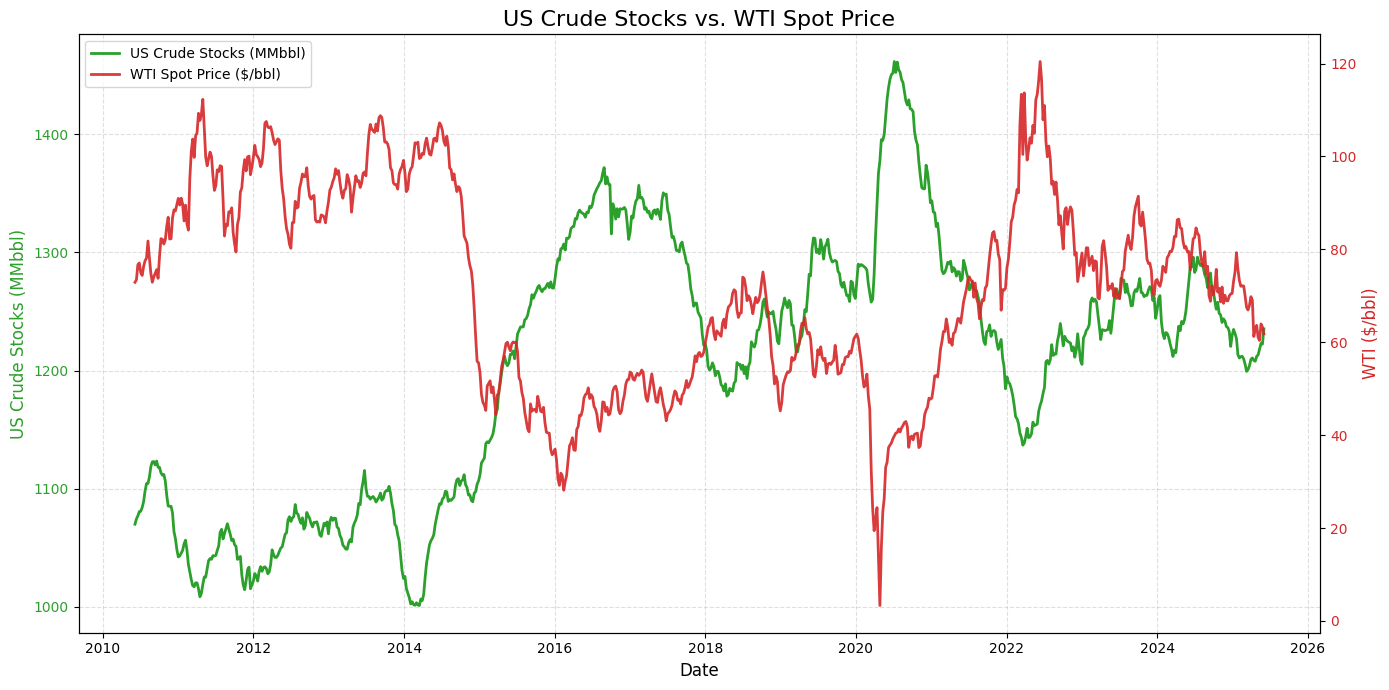

In [51]:
# US Crude Stocks vs. WTI Spot Price

stocks_col = "us_stock_kbbl"      # kbbl
wti_col    = "wti_spot_usd_bbl"   # $/bbl

# Scale stocks to million barrels (MMbbl)
stocks_mmbbl = df[stocks_col] / 1_000.0

fig, ax1 = plt.subplots(figsize=(14, 7))

# Left axis: Stocks (MMbbl)
c1 = "tab:green"
ax1.plot(df.index, stocks_mmbbl, color=c1, linewidth=2, label="US Crude Stocks (MMbbl)")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("US Crude Stocks (MMbbl)", color=c1, fontsize=12)
ax1.tick_params(axis="y", labelcolor=c1)
ax1.grid(True, linestyle="--", alpha=0.4)

# Right axis: WTI ($/bbl)
ax2 = ax1.twinx()
c2 = "tab:red"
ax2.plot(df.index, df[wti_col], color=c2, linewidth=2, alpha=0.9, label="WTI Spot Price ($/bbl)")
ax2.set_ylabel("WTI ($/bbl)", color=c2, fontsize=12)
ax2.tick_params(axis="y", labelcolor=c2)

# Combined legend
lines, labels = [], []
for ax in (ax1, ax2):
    lns, lbls = ax.get_legend_handles_labels()
    lines += lns; labels += lbls
ax1.legend(lines, labels, loc="upper left")

plt.title("US Crude Stocks vs. WTI Spot Price", fontsize=16)
plt.tight_layout()
plt.show()

The series show a clear inverse relationship: inventory builds generally align with weaker WTI, while draws coincide with firmer prices. The most prominent example is 2020, when a rapid stock build (COVID storage glut) overlapped with the WTI collapse (including the April 2020 anomaly). Earlier cyclical builds/draws (2015–2017) and the post-2021 normalization exhibit the same pattern. We plot stocks in MMbbl for readability and use data after short-lived outliers were removed; the COVID stock peak was not corrected because it reflects a sustained market condition, not a data error. This relationship also suggests potential lag effects worth testing in modeling. Storage build-up periods like 2015 and 2020 that coincided with price weakness.

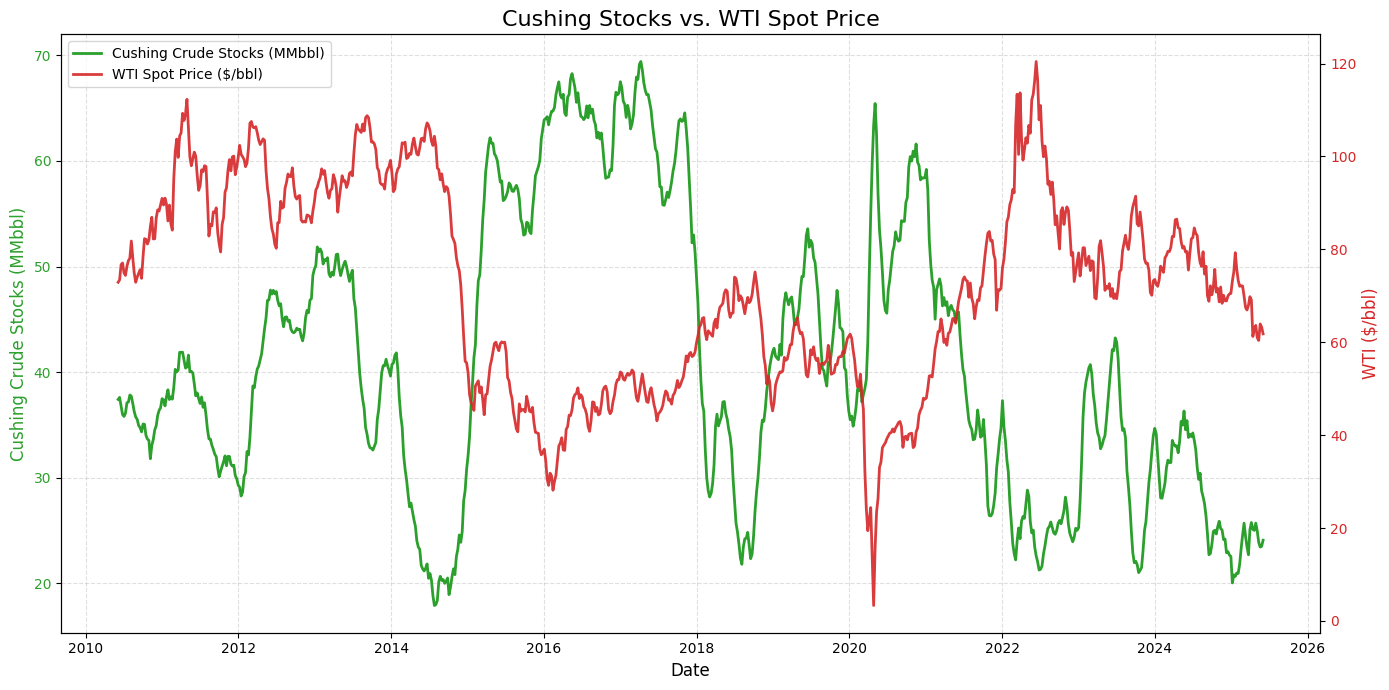

In [142]:
# Cushing Stocks vs. WTI Spot Price

stocks_col = "cushing_stock_kbbl"  # kbbl
wti_col    = "wti_spot_usd_bbl"    # $/bbl

# Scale stocks to million barrels (MMbbl)
stocks_mmbbl = df[stocks_col] / 1_000.0

fig, ax1 = plt.subplots(figsize=(14, 7))

# Left axis: Cushing stocks (MMbbl)
c1 = "tab:green"
ax1.plot(df.index, stocks_mmbbl, color=c1, linewidth=2, label="Cushing Crude Stocks (MMbbl)")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Cushing Crude Stocks (MMbbl)", color=c1, fontsize=12)
ax1.tick_params(axis="y", labelcolor=c1)
ax1.grid(True, linestyle="--", alpha=0.4)

# Right axis: WTI ($/bbl)
ax2 = ax1.twinx()
c2 = "tab:red"
ax2.plot(df.index, df[wti_col], color=c2, linewidth=2, alpha=0.9, label="WTI Spot Price ($/bbl)")
ax2.set_ylabel("WTI ($/bbl)", color=c2, fontsize=12)
ax2.tick_params(axis="y", labelcolor=c2)

# Combined legend
lines, labels = [], []
for ax in (ax1, ax2):
    lns, lbls = ax.get_legend_handles_labels()
    lines += lns; labels += lbls
ax1.legend(lines, labels, loc="upper left")

plt.title("Cushing Stocks vs. WTI Spot Price", fontsize=16)
plt.tight_layout()
plt.show()

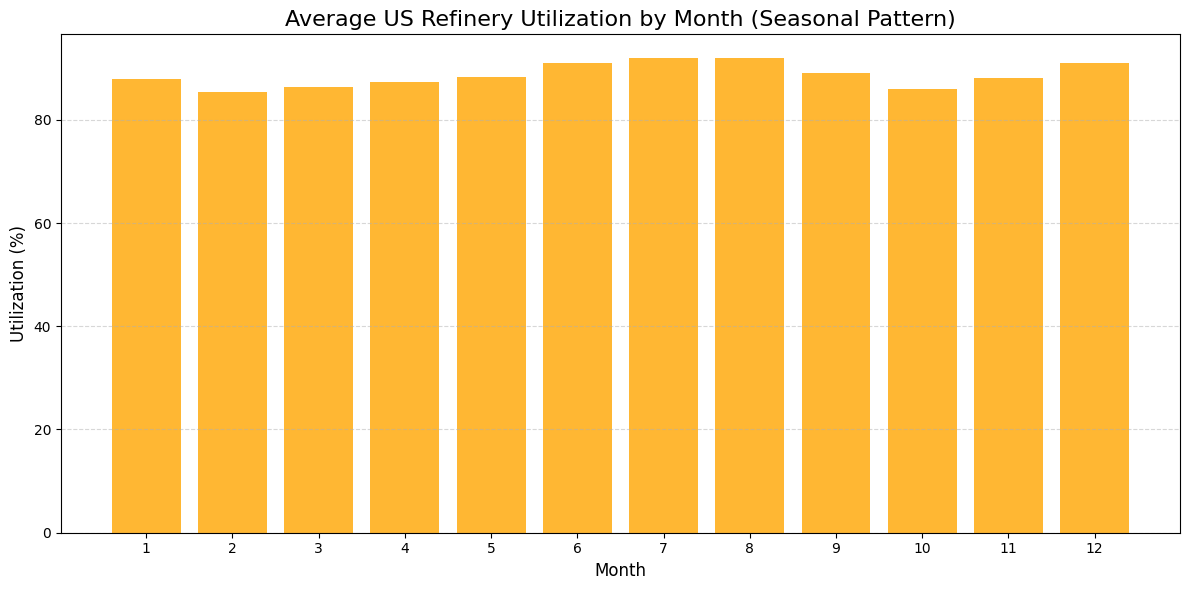

In [52]:
# Seasonal Pattern of US Refinery Utilization.

util_col = "us_refinery_util_prct"

# Extract month and group
monthly_util = df.groupby(df.index.month)[util_col].mean()

plt.figure(figsize=(12, 6))
plt.bar(monthly_util.index, monthly_util.values, color="orange", alpha=0.8)

plt.title("Average US Refinery Utilization by Month (Seasonal Pattern)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Utilization (%)", fontsize=12)
plt.xticks(range(1, 13))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

This chart shows the average US refinery utilization rate by month, revealing mild but consistent seasonal variation. Utilization typically peaks in the summer months (June–August) during the driving season and dips in early spring and autumn due to planned maintenance turnarounds. Winter months can also show reduced runs due to lower demand for gasoline, which the main product utilization driver.

While seasonal shifts are modest compared to major shock events (e.g., hurricanes, freezes, pandemics), they still provide valuable predictive signals for short-term WTI pricing and downstream market dynamics. These patterns will be useful when incorporating refinery utilization as an explanatory variable in the WTI Cushing price model.


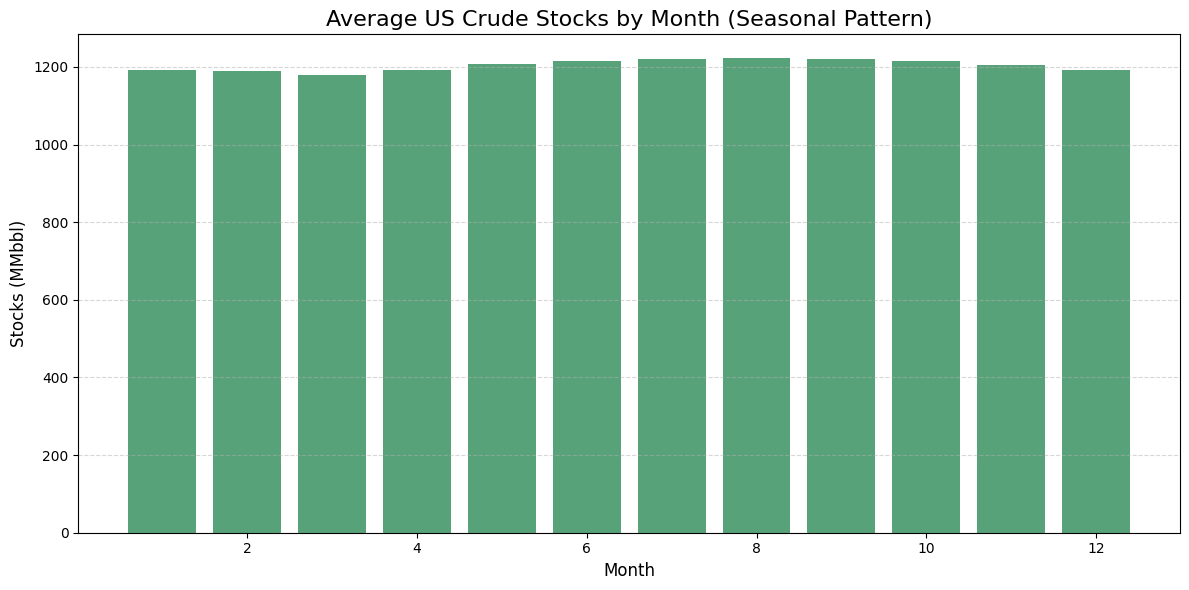

In [53]:
# Seasonal pattern of US Crude Stocks by month
stock_col = "us_stock_kbbl"  # adjust if different name
monthly_avg_stocks = df[stock_col].groupby(df.index.month).mean()

plt.figure(figsize=(12, 6))
plt.bar(monthly_avg_stocks.index, monthly_avg_stocks.values / 1_000, color="seagreen", alpha=0.8)
plt.title("Average US Crude Stocks by Month (Seasonal Pattern)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Stocks (MMbbl)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

This seasonal profile of US crude inventories shows relatively modest variation across months, with slightly higher stock levels in late summer (July–September) and early fall, coinciding with periods of lower refinery runs due to maintenance turnarounds. These builds tend to precede winter heating demand and the year-end driving season. Although the seasonal amplitude is small compared to short-term shocks, recognizing these patterns can help contextualize weekly stock reports and anticipate near-term supply balances.

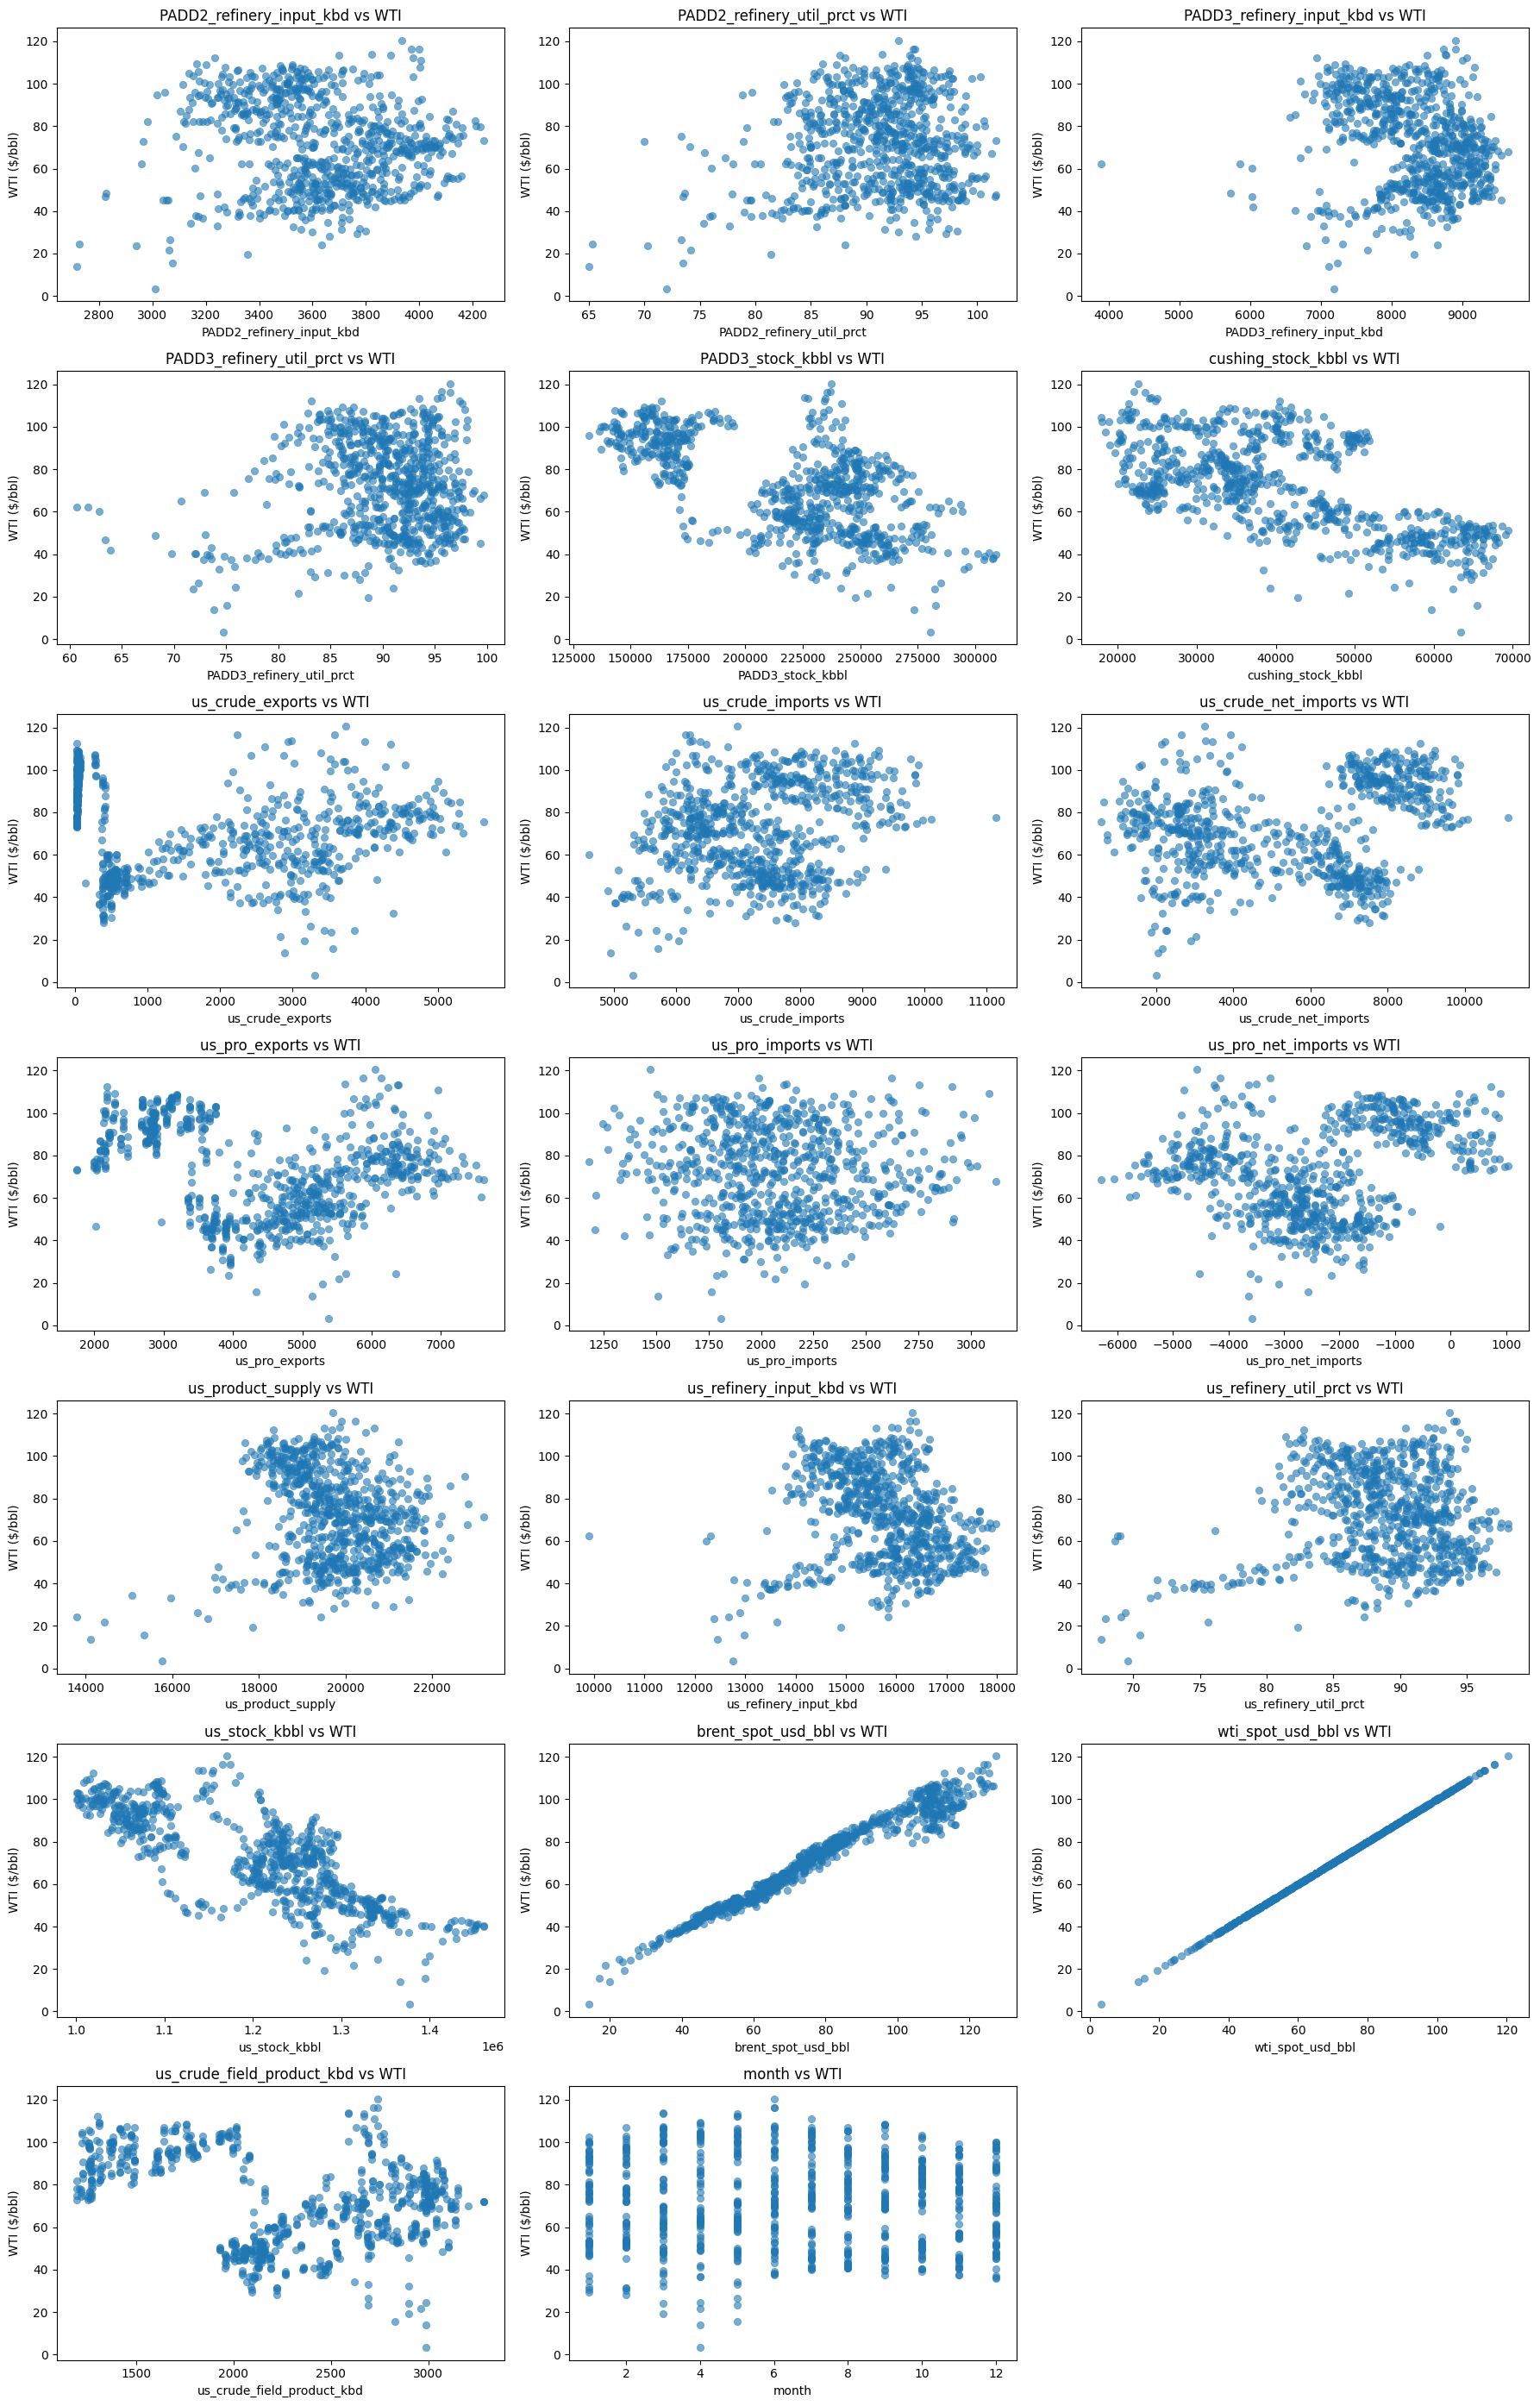

In [54]:
# Scatterplots for all the features vs WTI spot price

n_cols = 3
n_rows = int(np.ceil(len(df.columns) / n_cols))

plt.figure(figsize=(6*n_cols, 4*n_rows))

for i, col in enumerate(df.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=df[col], y=df['wti_spot_usd_bbl'], alpha=0.6, edgecolor=None)
    plt.xlabel(col, fontsize=10)
    plt.ylabel("WTI ($/bbl)", fontsize=10)
    plt.title(f"{col} vs WTI", fontsize=12)

plt.tight_layout()
plt.show()

The scatterplot grid highlights that inventory variables (U.S. total crude, PADD3, and especially Cushing stocks) are strongly inversely related to WTI prices, confirming the well-known supply pressure effect: higher stock levels tend to coincide with weaker crude prices. On the other hand, refinery utilization rates in PADD2, PADD3, and U.S. aggregates show a positive association with WTI, reflecting the demand pull from downstream activity.

Global benchmarks stand out, with Brent and WTI nearly perfectly correlated, while trade flow variables (imports/exports) and U.S. field production appear more scattered and noisy, suggesting weaker or regime-dependent relationships. Product supply provides some demand signal but with less consistency. Overall, the grid validates stocks and refinery runs as core explanatory drivers, while other fundamentals may require differencing, lags, or interaction terms to reveal their true influence.

## Feature selection / engineering

In this phase it will be ensured:

- Removes spurious trend, adds real signal: Δ (WoW) features strip persistence-driven correlations; selected levels (e.g., Cushing stocks) keep economically meaningful context.

- Captures timing effects: Lags 1–4 (and wti_lag1 for level targets) expose delayed responses that trees can model via thresholds and interactions.

- Context-aware structure: Seasonality and regime flags (export ban, COVID, TX freeze) let the models condition splits on known structural shifts instead of forcing the algorithm to rediscover them.

- Richer interactions without leakage: A few simple terms (e.g., stocks × utilization) give trees informative feature pairs, while history-bridging/trimming guarantees no fold-boundary NaNs and preserves time order.

### Differenced features (Δk):

We apply differencing to stabilize scale, reduce spurious trend correlations, and surface timing effects that may drive week-ahead moves in WTI

Δ1 (week-over-week): immediate shifts (e.g., surprise draws/builds) that can move prices next week.

Δ4 (~one month): monthly reporting/operational cycles; smooths weekly noise while capturing short-term momentum or reversals.

Δ12 (~one quarter): medium-term shifts (maintenance seasons, demand ramps) that unfold over several weeks.

Δ52 (year-over-year): seasonal context—how this week compares to the same week last year—useful for inventory levels and utilization.

We apply these transforms inside time-aware folds (no leakage), accept the shorter sample implied by lags, and retain a few economically meaningful levels (e.g., Cushing stocks, utilization) so the model sees both absolute conditions and their recent changes.

## Diff 1


In [55]:
# Double ensure my data is in chronological order
df = df.sort_index()

In [56]:
# Correlations: Levels vs WTI
target = "wti_spot_usd_bbl"

# Calculate Weekly differentials (keep NaNs; corr() handles them pairwise)
target_delta = target + "_delta"
df_diff = df.diff().rename(columns={target: target_delta})

# Correlation of levels with WTI
corr_levels = df.corr(method="spearman")[target].drop(target).dropna().sort_values(ascending=False)

# Correlation of differentias
corr_deltas = df_diff.corr(method="spearman")[target_delta].drop(target_delta).dropna().sort_values(ascending=False)
corr_deltas

variable
brent_spot_usd_bbl            0.874884
us_pro_net_imports            0.044108
us_refinery_util_prct         0.032638
us_crude_exports              0.029893
PADD3_refinery_util_prct      0.025774
us_pro_imports                0.025083
PADD3_refinery_input_kbd      0.018840
us_refinery_input_kbd         0.016716
PADD2_refinery_input_kbd      0.012909
us_product_supply             0.011670
PADD2_refinery_util_prct      0.010526
us_pro_exports               -0.004288
PADD3_stock_kbbl             -0.006112
us_crude_imports             -0.012776
us_crude_net_imports         -0.016044
us_crude_field_product_kbd   -0.027333
month                        -0.037507
us_stock_kbbl                -0.056068
cushing_stock_kbbl           -0.114348
Name: wti_spot_usd_bbl_delta, dtype: float64

In [57]:
# Let's make a comparisson

corr_comparison = pd.DataFrame({"Levels vs WTI": corr_levels, "Δ vs ΔWTI": corr_deltas}).sort_values("Δ vs ΔWTI", ascending=False)
display(corr_comparison.round(2))

Levels vs WTI  Δ vs ΔWTI
variable                                            
brent_spot_usd_bbl                   0.98       0.87
us_pro_net_imports                   0.25       0.04
us_refinery_util_prct               -0.06       0.03
us_crude_exports                    -0.29       0.03
PADD3_refinery_util_prct            -0.02       0.03
us_pro_imports                      -0.05       0.03
PADD3_refinery_input_kbd            -0.27       0.02
us_refinery_input_kbd               -0.28       0.02
PADD2_refinery_input_kbd            -0.17       0.01
us_product_supply                   -0.25       0.01
PADD2_refinery_util_prct             0.03       0.01
us_pro_exports                      -0.26      -0.00
PADD3_stock_kbbl                    -0.59      -0.01
us_crude_imports                     0.22      -0.01
us_crude_net_imports                 0.26      -0.02
us_crude_field_product_kbd          -0.29      -0.03
month                               -0.03      -0.04
us_stock_kbbl                       -0.81      -0.06
cushing_stock_kbbl                  -0.61      -0.11

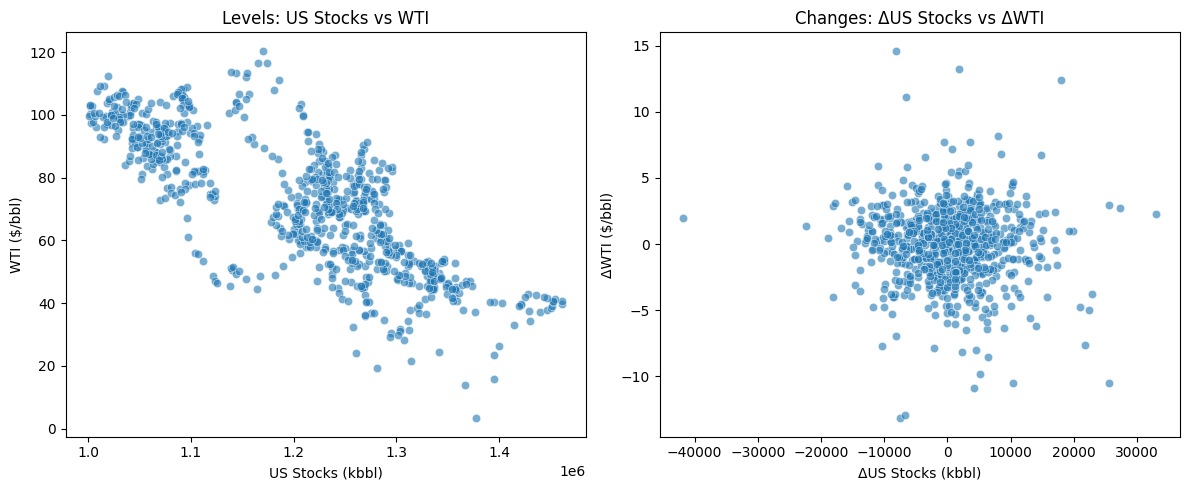

In [58]:
# Visualization: Example US_stocks
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(x=df["us_stock_kbbl"], y=df[target], alpha=0.6, ax=axes[0])
axes[0].set_title("Levels: US Stocks vs WTI")
axes[0].set_xlabel("US Stocks (kbbl)")
axes[0].set_ylabel("WTI ($/bbl)")

sns.scatterplot(x=df_diff["us_stock_kbbl"], y=df_diff[target_delta], alpha=0.6, ax=axes[1])
axes[1].set_title("Changes: ΔUS Stocks vs ΔWTI")
axes[1].set_xlabel("ΔUS Stocks (kbbl)")
axes[1].set_ylabel("ΔWTI ($/bbl)")

plt.tight_layout()
plt.show()

After calculating the differentials, we found that nearly all correlations between weekly changes in WTI spot price and changes in fundamentals collapse toward zero. Δ features are useful to remove the spurious trending correlation seen in levels, but also highlights that Δ features alone do not explain much of WTI’s weekly variation. To capture more signal, we could explore lagged effects (1–4 weeks), potential interactions, and non-linear models (e.g., tree ensembles) that can accommodate asymmetric impacts. At the same time, we will retain a few economically meaningful levels (such as Cushing stocks and refinery utilization), since absolute values remain relevant for market participants.

Lasso and Ridge do not capture non-linear relationships automatically; they remain linear models and require manually engineered features such as lags, squared terms, or interactions. Tree ensembles like Random Forest and XGBoost, by contrast, inherently model non-linearities and interactions, learning threshold effects and asymmetric impacts without manual feature creation.

I will use Lasso/Ridge for stable, interpretable linear rankings (ideal for a stakeholder “driver list”), and tree ensembles for capturing hidden non-linear or interaction effects to test whether they improve explanatory power.

## Other Diff evaluations

I have introduce lagged features manually because unlike non-linearities and interactions—which tree-based models can learn automatically—lags must be explicitly provided to capture delayed effects. Short lags (1 and 4 weeks) reflect immediate and monthly reporting cycles that often influence trading decisions, while a 12-week lag aligns with quarterly patterns such as refinery maintenance or seasonal demand. A yearly lag (52 weeks) allows us to see seasonality in the data, an important factor in petroleum markets. Creating these lags inevitably shortens the dataset by the maximum lag length, since the earliest weeks have no prior values to compare against, but this tradeoff ensures that the model has access to economically meaningful temporal dynamics.

### Lag 4:
Same week previous month

In [59]:
# Create lag 4 features for all numeric columns

target_delta4 = target + "_delta4"   # "wti_spot_usd_bbl_delta4"

# Differential Δ4
df_diff4 = df.diff(periods=4).dropna()
df_diff4 = df_diff4.rename(columns={target: target_delta4})

# --- Correlations: Δ4WTI vs Δ4(features) ---
corr_deltas4 = df_diff4.corr(method="spearman")[target_delta4].drop(target_delta4).sort_values(ascending=False)

corr_deltas4

variable
brent_spot_usd_bbl            0.898272
us_pro_net_imports            0.048046
us_crude_net_imports          0.028345
us_pro_imports                0.020217
us_crude_imports              0.019016
PADD2_refinery_input_kbd      0.013239
PADD2_refinery_util_prct      0.012391
PADD3_refinery_util_prct      0.000874
PADD3_refinery_input_kbd     -0.002417
us_refinery_input_kbd        -0.012164
us_refinery_util_prct        -0.015162
us_product_supply            -0.019699
us_crude_field_product_kbd   -0.023622
us_pro_exports               -0.040061
us_crude_exports             -0.042960
PADD3_stock_kbbl             -0.088079
month                        -0.091954
us_stock_kbbl                -0.170691
cushing_stock_kbbl           -0.259895
Name: wti_spot_usd_bbl_delta4, dtype: float64

In [60]:
corr_comparison["Δ4 vs Δ4WTI"] = corr_deltas4.reindex(corr_comparison.index)
corr_comparison

Levels vs WTI  Δ vs ΔWTI  Δ4 vs Δ4WTI
variable                                                         
brent_spot_usd_bbl               0.982101   0.874884     0.898272
us_pro_net_imports               0.251714   0.044108     0.048046
us_refinery_util_prct           -0.064640   0.032638    -0.015162
us_crude_exports                -0.292206   0.029893    -0.042960
PADD3_refinery_util_prct        -0.015847   0.025774     0.000874
us_pro_imports                  -0.054158   0.025083     0.020217
PADD3_refinery_input_kbd        -0.267586   0.018840    -0.002417
us_refinery_input_kbd           -0.277871   0.016716    -0.012164
PADD2_refinery_input_kbd        -0.174115   0.012909     0.013239
us_product_supply               -0.245596   0.011670    -0.019699
PADD2_refinery_util_prct         0.030064   0.010526     0.012391
us_pro_exports                  -0.264263  -0.004288    -0.040061
PADD3_stock_kbbl                -0.586235  -0.006112    -0.088079
us_crude_imports                 0.222516  -0.012776     0.019016
us_crude_net_imports             0.260644  -0.016044     0.028345
us_crude_field_product_kbd      -0.292269  -0.027333    -0.023622
month                           -0.029419  -0.037507    -0.091954
us_stock_kbbl                   -0.806281  -0.056068    -0.170691
cushing_stock_kbbl              -0.605453  -0.114348    -0.259895

## Diff 12
Same week previous quarter

In [61]:
# Create 12-week difference (Δ12) features

target_delta12 = target + "_delta12"   # "wti_spot_usd_bbl_delta12"

# Differential Δ12
df_diff12 = df.diff(periods=12).dropna()
df_diff12 = df_diff12.rename(columns={target: target_delta12})

# Correlations: Δ12WTI vs Δ12(features)
corr_deltas12 = df_diff12.corr(method="spearman")[target_delta12].drop(target_delta12).sort_values(ascending=False)

corr_comparison["Δ12 vs Δ12WTI"] = corr_deltas12.reindex(corr_comparison.index)

## Diff 52
Same week previous year (seasonality)

In [62]:
# Create 52-week difference (Δ52) features

target_delta52 = target + "_delta52"   # "wti_spot_usd_bbl_delta52"
df_diff52 = df.diff(periods=52).dropna().rename(columns={target: target_delta52})

# Correlations: Δ52WTI vs Δ52(features)
corr_deltas52 = df_diff52.corr(method="spearman")[target_delta52].drop(target_delta52).sort_values(ascending=False)

corr_comparison["Δ52 vs Δ52WTI"] = corr_deltas52.reindex(corr_comparison.index)
corr_comparison.round(2)

Levels vs WTI  Δ vs ΔWTI  Δ4 vs Δ4WTI  \
variable                                                            
brent_spot_usd_bbl                   0.98       0.87         0.90   
us_pro_net_imports                   0.25       0.04         0.05   
us_refinery_util_prct               -0.06       0.03        -0.02   
us_crude_exports                    -0.29       0.03        -0.04   
PADD3_refinery_util_prct            -0.02       0.03         0.00   
us_pro_imports                      -0.05       0.03         0.02   
PADD3_refinery_input_kbd            -0.27       0.02        -0.00   
us_refinery_input_kbd               -0.28       0.02        -0.01   
PADD2_refinery_input_kbd            -0.17       0.01         0.01   
us_product_supply                   -0.25       0.01        -0.02   
PADD2_refinery_util_prct             0.03       0.01         0.01   
us_pro_exports                      -0.26      -0.00        -0.04   
PADD3_stock_kbbl                    -0.59      -0.01        -0.09   
us_crude_imports                     0.22      -0.01         0.02   
us_crude_net_imports                 0.26      -0.02         0.03   
us_crude_field_product_kbd          -0.29      -0.03        -0.02   
month                               -0.03      -0.04        -0.09   
us_stock_kbbl                       -0.81      -0.06        -0.17   
cushing_stock_kbbl                  -0.61      -0.11        -0.26   

                            Δ12 vs Δ12WTI  Δ52 vs Δ52WTI  
variable                                                  
brent_spot_usd_bbl                   0.91           0.96  
us_pro_net_imports                   0.07          -0.15  
us_refinery_util_prct                0.03           0.34  
us_crude_exports                     0.05          -0.04  
PADD3_refinery_util_prct             0.04           0.30  
us_pro_imports                       0.09           0.01  
PADD3_refinery_input_kbd             0.04           0.30  
us_refinery_input_kbd                0.03           0.36  
PADD2_refinery_input_kbd             0.05           0.29  
us_product_supply                    0.01           0.15  
PADD2_refinery_util_prct             0.04           0.27  
us_pro_exports                      -0.05           0.21  
PADD3_stock_kbbl                    -0.08          -0.63  
us_crude_imports                     0.04           0.20  
us_crude_net_imports                -0.01           0.14  
us_crude_field_product_kbd          -0.01          -0.01  
month                               -0.04           0.02  
us_stock_kbbl                       -0.30          -0.76  
cushing_stock_kbbl                  -0.31          -0.64

**Key observations after the lags**

Brent ≈ WTI: Extremely high in all views (levels 0.98; Δ/Δ4/Δ12/Δ52 ≥0.87). Using Brent will dominate the model; consider targeting the Brent–WTI spread instead, or exclude Brent to focus on fundamentals.

Inventories drive prices (inverse): US stocks and Cushing are strongly negative at levels (−0.81, −0.61) and YoY (Δ52) (−0.76, −0.64). Shorter diffs (Δ, Δ4, Δ12) are weak—weekly noise masks the effect.

Runs/utilization show seasonality link: US/PADD3 utilization & inputs weak at Δ/Δ4/Δ12 but positive at Δ52 (~0.30–0.36), consistent with seasonal demand/maintenance cycles.

Trade flows & product supply: Generally low contemporaneous signal across Δ/Δ4/Δ12; modest YoY signals at best. Production has near-zero correlation everywhere. Lasso/Ridge may give them low importnace

## Feature choices: levels vs. differences

EDA shows that weekly/short-horizon differences (Δ1, Δ4, Δ12) have very weak contemporaneous correlation with ΔWTI, while year-over-year differences (Δ52) retain meaningful signal, especially for refinery utilization/inputs (positive) and inventories (negative). Economically, Δ1/Δ4/Δ12 strip trend but mostly amplify weekly noise; in contrast, Δ52 captures seasonality (turnarounds, driving season, heating season) and therefore preserves structure that matters for price dynamics. Accordingly, I will exclude Δ4 and Δ12 (no material improvement) and keep Δ52 for stocks, utilization, and inputs. We also retain All levels, since absolute value levels are economically meaningful and display the strongest relationship with WTI.

Brent is almost a one-for-one proxy for WTI in the data (ρ≈0.98 across levels and ≥0.87 across differences). Including it would dominate the model and drown out fundamentals, effectively turning the task into “predict WTI with Brent.” so we drop Brent spot price.

In [63]:
# Start from ALL levels
df_final = df.copy()

In [64]:
# First, let's drop brent and month
df_final = df_final.drop(columns=["brent_spot_usd_bbl", "month"])

In [65]:
# Ensure time-sorted weekly so diff(52) meant "same week last year"
assert isinstance(df.index, pd.DatetimeIndex), "df.index must be a DatetimeIndex"
assert df.index.is_monotonic_increasing, "df must be sorted by date ascending"

In [66]:
# Columns for which we want to add Δ52 (YoY) features
delta52_cols = [
    "us_refinery_util_prct",
    "PADD3_refinery_util_prct",
    "us_refinery_input_kbd",
    "PADD2_refinery_input_kbd",
    "PADD2_refinery_util_prct",
    "PADD3_stock_kbbl",
    "cushing_stock_kbbl",
]

In [67]:
# Each new column is named <original>_delta52
for col in delta52_cols:
    df_final[f"{col}_delta52"] = df_diff52[col]

In [68]:
df_final.shape

(783, 25)

In [69]:
df.shape

(783, 20)

In [70]:
# Double check nulls are ONLY the 1st week.
df_final.isna().sum()

variable
PADD2_refinery_input_kbd             0
PADD2_refinery_util_prct             0
PADD3_refinery_input_kbd             0
PADD3_refinery_util_prct             0
PADD3_stock_kbbl                     0
cushing_stock_kbbl                   0
us_crude_exports                     0
us_crude_imports                     0
us_crude_net_imports                 0
us_pro_exports                       0
us_pro_imports                       0
us_pro_net_imports                   0
us_product_supply                    0
us_refinery_input_kbd                0
us_refinery_util_prct                0
us_stock_kbbl                        0
wti_spot_usd_bbl                     0
us_crude_field_product_kbd           0
us_refinery_util_prct_delta52       52
PADD3_refinery_util_prct_delta52    52
us_refinery_input_kbd_delta52       52
PADD2_refinery_input_kbd_delta52    52
PADD2_refinery_util_prct_delta52    52
PADD3_stock_kbbl_delta52            52
cushing_stock_kbbl_delta52          52
dtype: int64

# Dropping first 52 weeks Justification

We drop the first 52 weeks because year-over-year features (Δ52) require a full prior year by construction. Keeping those early rows would force us to impute Δ52 (injecting noise/bias into a seasonal signal) or to train on inconsistent feature sets (rows without Δ52 vs. rows with Δ52), both of which harm out-of-sample validity and can leak information during time-series CV. Dropping the warm-up year guarantees that every observation has the same engineered features, aligns seasonality correctly, and avoids any imputation of structurally undefined values.

The cost is small and the dataset remains strong: from ~783 weekly observations we retain ~731 (≈93% of the sample), still spanning 2011–2025. That’s ample data for regularized linear models and tree ensembles, supports robust walk-forward cross-validation, and preserves the Δ52 seasonal signal that our EDA shows is informative (e.g., inventories negative YoY; utilization/inputs positive YoY). In short: the one-year warm-up drop improves feature integrity and evaluation quality with minimal impact on statistical power.

In [71]:
# let's double check all the nan are the 1st 52 rows
df_final.iloc[:52].isna().sum()

variable
PADD2_refinery_input_kbd             0
PADD2_refinery_util_prct             0
PADD3_refinery_input_kbd             0
PADD3_refinery_util_prct             0
PADD3_stock_kbbl                     0
cushing_stock_kbbl                   0
us_crude_exports                     0
us_crude_imports                     0
us_crude_net_imports                 0
us_pro_exports                       0
us_pro_imports                       0
us_pro_net_imports                   0
us_product_supply                    0
us_refinery_input_kbd                0
us_refinery_util_prct                0
us_stock_kbbl                        0
wti_spot_usd_bbl                     0
us_crude_field_product_kbd           0
us_refinery_util_prct_delta52       52
PADD3_refinery_util_prct_delta52    52
us_refinery_input_kbd_delta52       52
PADD2_refinery_input_kbd_delta52    52
PADD2_refinery_util_prct_delta52    52
PADD3_stock_kbbl_delta52            52
cushing_stock_kbbl_delta52          52
dtype: int64

YES! we can drop all NAN, so basically we are dropping the first year

In [72]:
# Define df_model
df_model = df_final.copy()
df_model = df_model.dropna()
df_model.shape

(731, 25)

## Baseline Naive Forecast with seasonality

I include naïve baselines with seasonality (last-week persistence and seasonal-naïve using the value from t-52 weeks) to establish a transparent, low-variance benchmark that any model must beat.

Weekly WTI prices exhibit pronounced seasonal structure—refinery turnarounds, driving/heating seasons, and regular demand/supply cycles—so a t-52 baseline captures much of this pattern without fitting parameters or risking overfit. This makes it an honest “floor” for performance and a direct test of whether our engineered features (especially Δ52) add value beyond seasonality alone.

Operationally, these baselines are trivial to compute, immune to multicollinearity, and highly interpretable for stakeholders (“this week looks like last week / same week last year”). We’ll report MAE, MAPE, RMSE, and R² on a 52-week hold-out for the naïves and then for Ridge/Lasso. If regularized models don’t outperform both naïve baselines, they’re not delivering incremental predictive power.

With this approach, we already performed a walk-forward (rolling-origin) evaluation and used a naïve last-week forecast as the baseline comparator; model metrics are reported per fold and on the 52-week holdout relative to this baseline

In [73]:
# Let's calculate Baseline with white noise and seasonal component

y = df_model["wti_spot_usd_bbl"]
y_test = y.iloc[-52:]

# Naïve baselines
y_pred_last        = y.shift(1).loc[y_test.index]      # persistence, white noise
y_pred_seasonal52  = y.shift(52).loc[y_test.index]     # seasonal naïve

# Blended naïve (average of last-week and t-52) - BASELINE !
y_pred_blend = ((y.shift(1) + y.shift(52)) / 2).loc[y_test.index]

In [74]:
# Score my Baseline function

def report(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:14s} MAE={mae:.2f}  MAPE={mape:.3f}  RMSE={rmse:.2f}  R2={r2:.3f}")

In [75]:
report("Last-week",      y_test, y_pred_last)
report("Seasonal-52",    y_test, y_pred_seasonal52)
report("Blend(1,52)",    y_test, y_pred_blend)

Last-week      MAE=2.18  MAPE=0.030  RMSE=2.73  R2=0.795
Seasonal-52    MAE=10.37  MAPE=0.150  RMSE=12.37  R2=-3.215
Blend(1,52)    MAE=5.64  MAPE=0.081  RMSE=6.73  R2=-0.248


**Important**

The baseline results confirm that a simple one-week persistence model explains nearly 80% of the variance in WTI prices, while seasonal and blended approaches perform poorly. This highlights the strong autoregressive structure of crude prices. However, our goal is not to forecast the WTI spot price per se, but to use machine learning to rank and quantify which EIA-reported fundamentals most influence WTI. From that perspective, a purely autoregressive baseline does not provide incremental value—it serves only as a statistical control. The true contribution of the model lies in isolating and ranking the top drivers among EIA variables, not in beating a persistence forecast of the price itself.

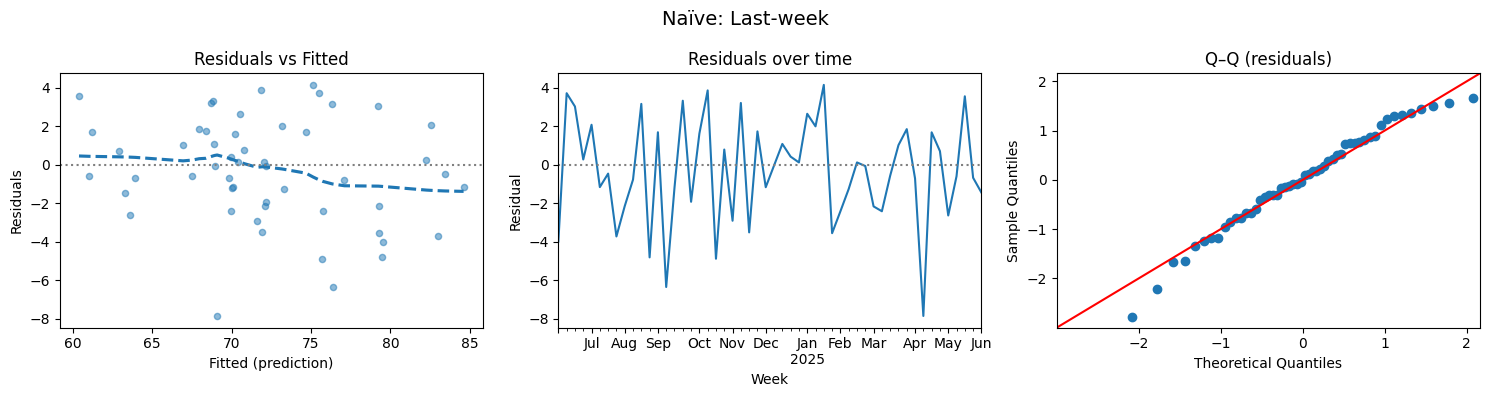

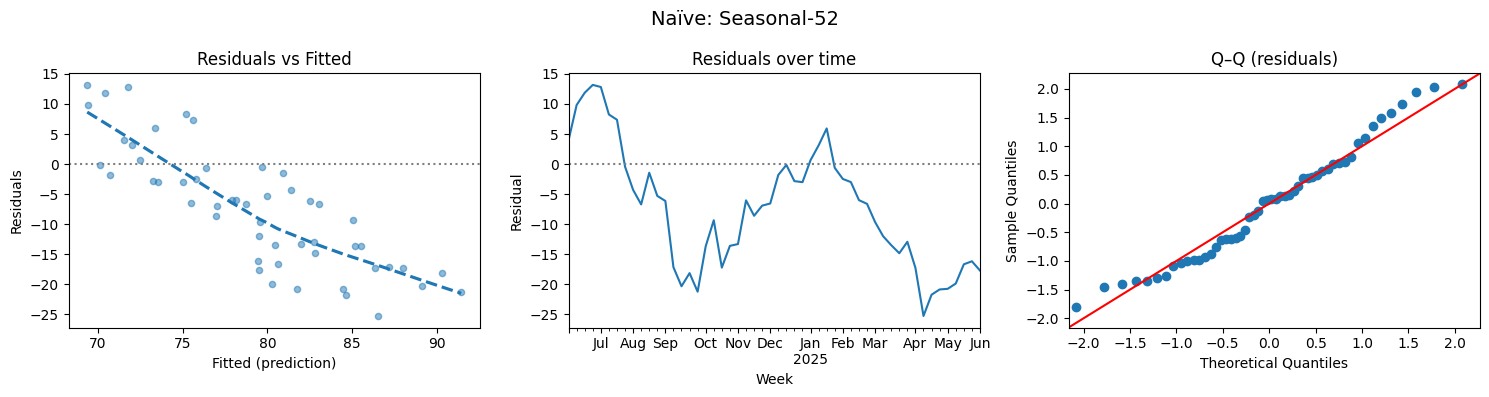

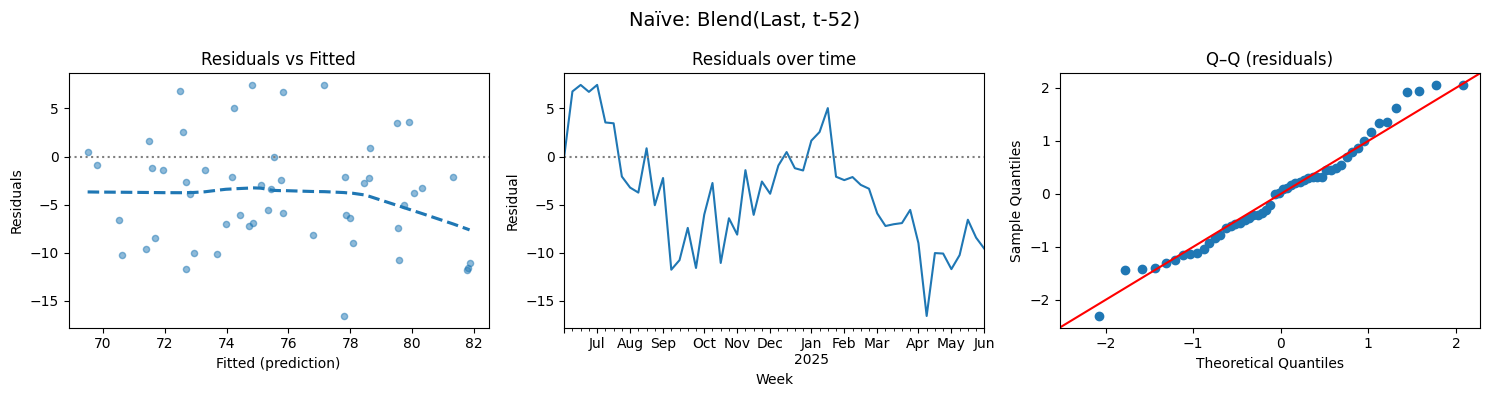

In [76]:
# Some Plots from the baseline models

def plot_resid_diagnostics(y_true, y_pred, title):
    # Align and drop NaNs
    y_true = y_true.astype(float)
    y_pred = y_pred.astype(float)
    mask = y_true.notna() & y_pred.notna()
    yt, yp = y_true[mask], y_pred[mask]
    res = yt - yp

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(title, fontsize=14)

    # 1) Residuals vs Fitted
    sns.regplot(x=yp.values, y=res.values, lowess=True,
                scatter_kws={'alpha':0.5, 's':20},
                line_kws={'linestyle':'--'}, ax=axs[0])
    axs[0].axhline(0, color='gray', linestyle=':')
    axs[0].set_xlabel("Fitted (prediction)")
    axs[0].set_ylabel("Residuals")
    axs[0].set_title("Residuals vs Fitted")

    # 2) Residual time series
    res.plot(ax=axs[1], lw=1.5)
    axs[1].axhline(0, color='gray', linestyle=':')
    axs[1].set_title("Residuals over time")
    axs[1].set_xlabel("Week")
    axs[1].set_ylabel("Residual")

    # 3) Q-Q plot
    sm.qqplot(res.values, line='45', fit=True, ax=axs[2])
    axs[2].set_title("Q–Q (residuals)")

    plt.tight_layout()
    plt.show()

# Run for the three baselines on your hold-out (y_test, y_pred_last, y_pred_seasonal52, y_pred_blend)
plot_resid_diagnostics(y_test, y_pred_last,       "Naïve: Last-week")
plot_resid_diagnostics(y_test, y_pred_seasonal52, "Naïve: Seasonal-52")
plot_resid_diagnostics(y_test, y_pred_blend,      "Naïve: Blend(Last, t-52)")


**Key Observations**

Residuals vs fitted show a gentle S-shape: at low fitted values residuals skew a bit positive (model underpredicts), and at high fitted values residuals skew negative (model overpredicts). That’s mild mean-reversion the last-week rule can’t capture. Variance looks fairly stable (no strong funnel), with a few big misses.

The Q–Q plot hugs the 45° line except at the ends, indicating heavy tails/outliers rather than systematic misfit.

## Regularization (Lasso/Ridge)

In [77]:
X = df_model.drop(columns=[target]).copy()
y = df_model[target].copy()

**Preprocessing Block**

ColumnTransformer inside a Pipeline guarantees these steps are fit only on the training folds in TimeSeriesSplit, preventing leakage into validation. It also keeps it reproducible and identical at train/test time.

Median imputation handles the occasional gaps, robust to outliers and skew.

Standardization (StandardScaler) puts every feature on the same scale (mean 0, std 1). That’s essential for Ridge/Lasso, whose L2/L1 penalties depend on feature scale. Without scaling, variables in big units (kbbl) would dominate ones in % or kbd, and the regularization path/α search becomes unstable. Scaling also improves solver convergence and makes standardized coefficients comparable for ranking.

In [78]:
# Use Last year (52 weeks) to test
HOLDOUT_WEEKS = 52

X_train, X_test = X.iloc[:-HOLDOUT_WEEKS], X.iloc[-HOLDOUT_WEEKS:]
y_train, y_test = y.iloc[:-HOLDOUT_WEEKS], y.iloc[-HOLDOUT_WEEKS:]

In [79]:
# Cross Validation Set up

tscv = TimeSeriesSplit(n_splits=5)  # n_splits=5 prevents look-ahead leakage
param_grid = {"reg__alpha": np.logspace(-3, 3, 13)} # Useful regularization strengths span orders of magnitude
scorer = "neg_mean_absolute_error"     # GridSearchCV to maximize (less negative = better)

# Justification adjustment in our df

Because the one-week persistence model already explains nearly 80% of the variance on the hold-out set, WTI clearly exhibits strong autoregressive behavior. This makes last week’s WTI (wti_lag1) an essential control variable when testing whether fundamentals add explanatory power beyond this baseline. Importantly, the EIA’s reported WTI figure is a prior-week average that is released mid-week of the following week, so the information is contemporaneously available and does not create look-ahead bias. Including wti_lag1 therefore both captures the dominant short-horizon momentum in crude prices and stabilizes the modeling framework—particularly relevant given the unstable and sometimes negative R² observed in Ridge regressions without the lag term.

At the same time, we acknowledge that WTI is heavily influenced by external factors (e.g., geopolitics, OPEC policy, macro sentiment) that move prices in real time, so we do not expect this model to fully drive or predict the direction of WTI, but rather to isolate the incremental role of reported fundamentals against the autoregressive baseline

**Important**

The primary objective of this project is not to predict the exact level of WTI spot prices, but rather to identify and rank the fundamental drivers reported in the EIA Weekly Petroleum Status Report that most influence WTI from a machine learning perspective. While baseline models such as a one-week persistence (AR1) confirm that WTI exhibits strong autoregressive behavior and can explain nearly 80% of price variance, this is not the focus of our analysis. Instead, these baselines are used strictly as controls to ensure that any incremental explanatory power from fundamentals is measured consistently. Model performance is therefore not judged by forecast error alone, but by the ability to isolate, quantify, and rank the top features that drive crude oil price dynamics. AR model will be kept as it is.

# Baseline #2

The correlation heatmap shows strong multicollinearity across refinery utilization, imports/exports, and stock variables (e.g., us_crude_imports at 0.89 with us_crude_exports; PADD3_refinery_input_kbd at 0.91 with us_refinery_input_kbd). Because of this, a naïve OLS model would be unstable if we attempted to include all variables simultaneously.

As a practical baseline, we therefore specify a simplified linear model: **wti_spot_price = f(PADD3_refinery_input_kbd, us_stock_kbbl, us_crude_imports, us_crude_field_product_kbd)**.

This selection was guided by two principles:

- Coverage across categories choosing one representative from refinery activity, inventories, trade flows, and production.

- Highest correlations with WTI: e.g., us_crude_field_product_kbd (0.75), us_crude_imports (0.78), PADD3_refinery_input_kbd (0.55), and us_stock_kbbl (0.62).

This baseline is intentionally simple: it acknowledges collinearity while still anchoring the model on the most correlated fundamentals from each major supply/demand block. It sets a transparent benchmark against which more advanced machine learning models can be compared.

## Adjustment to df_model

To align fundamentals with subsequent price movements, we created a forward-shifted WTI column so that EIA variables observed in week n are matched against WTI spot prices in week n+1. This ensures that reported fundamentals are evaluated for their impact on the following week’s price, consistent with the timing of market information flow.

In [80]:
df_model['wti_t_plus_1'] = df_model['wti_spot_usd_bbl'].shift(-1)
df_model.tail()

variable    PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
date                                                             
2025-05-04                    3697.0                      88.8   
2025-05-11                    3874.0                      91.8   
2025-05-18                    3882.0                      91.5   
2025-05-25                    3859.0                      91.0   
2025-06-01                    3992.0                      94.0   

variable    PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
date                                                             
2025-05-04                    9146.0                      92.5   
2025-05-11                    9287.0                      93.3   
2025-05-18                    9201.0                      92.4   
2025-05-25                    9160.0                      92.6   
2025-06-01                    9467.0                      95.5   

variable    PADD3_stock_kbbl  cushing_stock_kbbl  us_crude_exports  \
date                                                                 
2025-05-04          249426.0             24961.0            4006.0   
2025-05-11          251322.0             23892.0            3369.0   
2025-05-18          251324.0             23435.0            3507.0   
2025-05-25          248248.0             23510.0            4301.0   
2025-06-01          245104.0             24086.0            3907.0   

variable    us_crude_imports  us_crude_net_imports  us_pro_exports  ...  \
date                                                                ...   
2025-05-04            6056.0                2050.0          6645.0  ...   
2025-05-11            5841.0                2472.0          7583.0  ...   
2025-05-18            6089.0                2582.0          6566.0  ...   
2025-05-25            6351.0                2050.0          6880.0  ...   
2025-06-01            6346.0                2439.0          6189.0  ...   

variable    wti_spot_usd_bbl  us_crude_field_product_kbd  \
date                                                       
2025-05-04           60.9900                      3083.0   
2025-05-11           60.3920                      3040.0   
2025-05-18           63.9420                      3040.0   
2025-05-25           63.2640                      3040.0   
2025-06-01           61.8175                      3040.0   

variable    us_refinery_util_prct_delta52  PADD3_refinery_util_prct_delta52  \
date                                                                          
2025-05-04                            0.5                               1.8   
2025-05-11                           -0.2                               0.6   
2025-05-18                           -1.0                              -1.3   
2025-05-25                           -4.1                              -2.0   
2025-06-01                           -2.0                              -0.8   

variable    us_refinery_input_kbd_delta52  PADD2_refinery_input_kbd_delta52  \
date                                                                          
2025-05-04                          123.0                             108.0   
2025-05-11                          146.0                              42.0   
2025-05-18                            8.0                            -117.0   
2025-05-25                         -755.0                            -301.0   
2025-06-01                         -146.0                            -238.0   

variable    PADD2_refinery_util_prct_delta52  PADD3_stock_kbbl_delta52  \
date                                                                     
2025-05-04                               3.6                   -9622.0   
2025-05-11                               1.0                   -6560.0   
2025-05-18                              -3.3                  -10182.0   
2025-05-25                              -7.6                   -9969.0   
2025-06-01                              -5.9                  -15459.0   

variable 

To address the missing value in wti_lag1 on 2025-06-01, we aligned it with the forward WTI spot price from the canonical weekly price series. Specifically, wti_lag1 for week n is defined as the observed WTI in week n+1; therefore, the missing entry was filled with 64.06 USD/bbl from 2025-06-08. This ensures consistency in the forward-lag structure across the dataset.

In [81]:
weekly_prices.tail(14)

variable    brent_spot_usd_bbl  wti_spot_usd_bbl
date                                            
2025-05-11              62.290           60.3920
2025-05-18              65.536           63.9420
2025-05-25              65.864           63.2640
2025-06-01              64.740           61.8175
2025-06-08              67.176           64.0600
2025-06-15              71.054           68.6260
2025-06-22              78.246           74.9400
2025-06-29              69.962           66.7780
2025-07-06              69.606           67.4325
2025-07-13              71.774           69.1460
2025-07-20              70.656           68.0740
2025-07-27              70.086           67.1080
2025-08-03              72.408           69.5840
2025-08-10              69.560           67.3300

In [82]:
# For the row 2025-06-01 in df, take the WTI value at 2025-06-08 from weekly_prices
forward_value = weekly_prices.loc['2025-06-08', 'wti_spot_usd_bbl']
forward_value

np.float64(64.06)

In [83]:
df_model.loc['2025-06-01', 'wti_t_plus_1'] = forward_value
df_model.tail()

variable    PADD2_refinery_input_kbd  PADD2_refinery_util_prct  \
date                                                             
2025-05-04                    3697.0                      88.8   
2025-05-11                    3874.0                      91.8   
2025-05-18                    3882.0                      91.5   
2025-05-25                    3859.0                      91.0   
2025-06-01                    3992.0                      94.0   

variable    PADD3_refinery_input_kbd  PADD3_refinery_util_prct  \
date                                                             
2025-05-04                    9146.0                      92.5   
2025-05-11                    9287.0                      93.3   
2025-05-18                    9201.0                      92.4   
2025-05-25                    9160.0                      92.6   
2025-06-01                    9467.0                      95.5   

variable    PADD3_stock_kbbl  cushing_stock_kbbl  us_crude_exports  \
date                                                                 
2025-05-04          249426.0             24961.0            4006.0   
2025-05-11          251322.0             23892.0            3369.0   
2025-05-18          251324.0             23435.0            3507.0   
2025-05-25          248248.0             23510.0            4301.0   
2025-06-01          245104.0             24086.0            3907.0   

variable    us_crude_imports  us_crude_net_imports  us_pro_exports  ...  \
date                                                                ...   
2025-05-04            6056.0                2050.0          6645.0  ...   
2025-05-11            5841.0                2472.0          7583.0  ...   
2025-05-18            6089.0                2582.0          6566.0  ...   
2025-05-25            6351.0                2050.0          6880.0  ...   
2025-06-01            6346.0                2439.0          6189.0  ...   

variable    wti_spot_usd_bbl  us_crude_field_product_kbd  \
date                                                       
2025-05-04           60.9900                      3083.0   
2025-05-11           60.3920                      3040.0   
2025-05-18           63.9420                      3040.0   
2025-05-25           63.2640                      3040.0   
2025-06-01           61.8175                      3040.0   

variable    us_refinery_util_prct_delta52  PADD3_refinery_util_prct_delta52  \
date                                                                          
2025-05-04                            0.5                               1.8   
2025-05-11                           -0.2                               0.6   
2025-05-18                           -1.0                              -1.3   
2025-05-25                           -4.1                              -2.0   
2025-06-01                           -2.0                              -0.8   

variable    us_refinery_input_kbd_delta52  PADD2_refinery_input_kbd_delta52  \
date                                                                          
2025-05-04                          123.0                             108.0   
2025-05-11                          146.0                              42.0   
2025-05-18                            8.0                            -117.0   
2025-05-25                         -755.0                            -301.0   
2025-06-01                         -146.0                            -238.0   

variable    PADD2_refinery_util_prct_delta52  PADD3_stock_kbbl_delta52  \
date                                                                     
2025-05-04                               3.6                   -9622.0   
2025-05-11                               1.0                   -6560.0   
2025-05-18                              -3.3                  -10182.0   
2025-05-25                              -7.6                   -9969.0   
2025-06-01                              -5.9                  -15459.0   

variable 

In [84]:
df_model.shape

(731, 26)

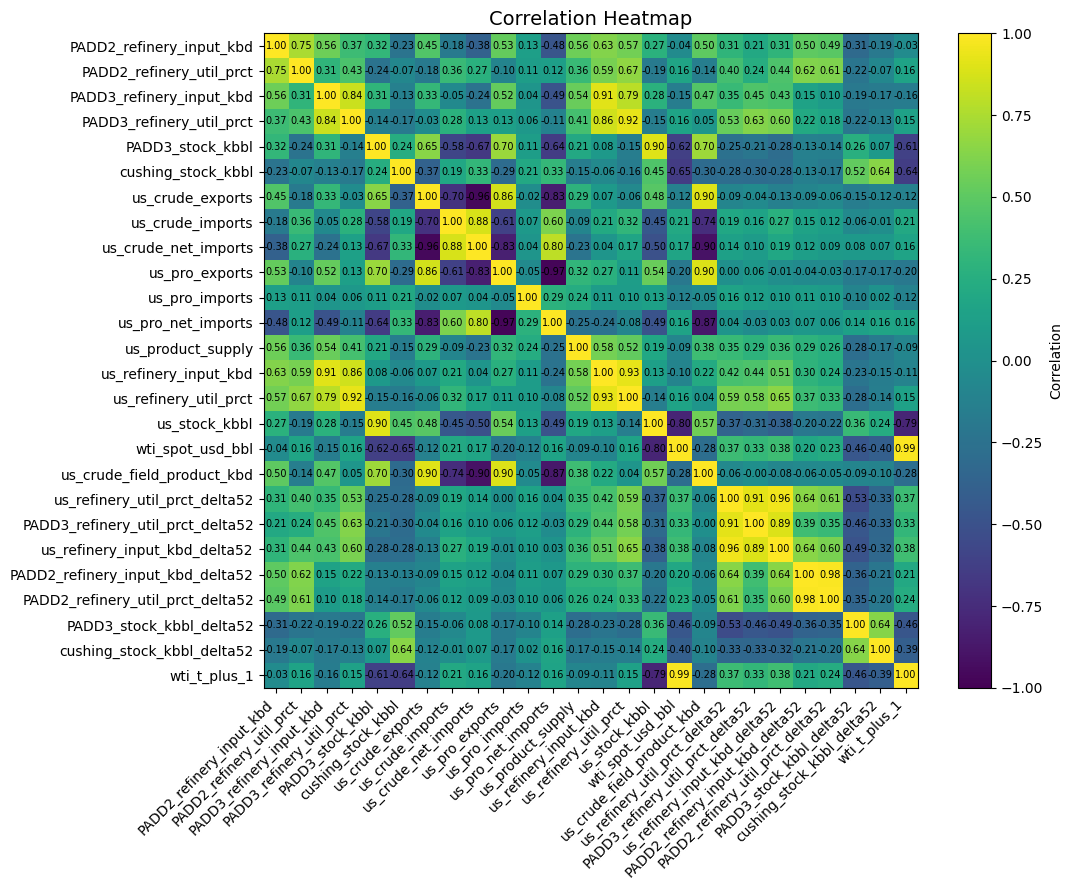

In [85]:
# New Heatmap df_model

corr = df_model.corr(numeric_only=True)

# Heatmap
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

# Ticks & labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation', rotation=90)

# Cells with values
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i, j]:.2f}",
                ha='center', va='center', fontsize=7)

plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

In both heatmaps, WTI spot maintains its strongest positive correlations with U.S. crude field production (~0.75), U.S. crude imports (~0.64–0.65), and U.S. stock levels (~0.62). This stability confirms that supply, imports, and inventories remain the most relevant fundamental linkages to WTI.

## Baseline OLS

In [86]:
# Use Last year (52 weeks) to test
HOLDOUT_WEEKS = 52
y_col = 'wti_t_plus_1'

X_train, X_test = X.iloc[:-HOLDOUT_WEEKS], X.iloc[-HOLDOUT_WEEKS:]
y_train, y_test = df_model[y_col].iloc[:-HOLDOUT_WEEKS], df_model[y_col].iloc[-HOLDOUT_WEEKS:]

In [87]:
# Define baseline features (one per supply/demand block)
feature_cols = [
    'PADD3_refinery_input_kbd',   # Refinery activity
    'us_stock_kbbl',              # Inventories
    'us_crude_imports',           # Imports
    'us_crude_field_product_kbd']  # Production

In [88]:
# Fit OLS baseline
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [89]:
y_pred = ols.predict(X_test)

In [90]:
report("OLS Baseline", y_test, y_pred)

OLS Baseline   MAE=9.39  MAPE=0.136  RMSE=10.93  R2=-2.219


### Regularization - Part 2

We will skip imputation because the modeling dataset was pre-cleaned to **0% missingness**—all gaps were resolved upstream before the baselines. With only complete numeric features, a `SimpleImputer` would add no value; if future Δ/lag engineering inside the tree pipelines introduces fold-boundary NaNs, we’ll handle them within the FeatureBuilder (history-bridging or trimming) rather than at this stage.

All features are numeric, so for Ridge/Lasso we use a simple ColumnTransformer that standardizes inputs—this is sufficient for the linear baselines. To match the checklist and guard against any NaNs from future diffs/lags, we add a median imputer before the scaler and omit any categorical passthrough since there are no categorical variables.

We tune Ridge and Lasso with **GridSearchCV + TimeSeriesSplit**, so we don’t need to use **RidgeCV/LassoCV (Linear models with time-aware CV)**—this setup is functionally equivalent for selecting α while preserving time order and avoiding leakage.

We don't need FeatureBuilder, it was already engineered upstream: Weekly Δ features, outlier handling, target alignment (wti_t_plus_1), and NaN removal were completed in data prep; re-creating them inside the pipeline would duplicate work with no added signal. 0% missingness contract: Our modeling dataset is fully complete; avoiding in-pipeline transforms preserves that invariant and removes the need for imputers or additional guards.


## Ridge

In [91]:
# Use Last year (52 weeks) to test
HOLDOUT_WEEKS = 52
y_col = 'wti_t_plus_1'

X_train_ridge, X_test_ridge = X.iloc[:-HOLDOUT_WEEKS], X.iloc[-HOLDOUT_WEEKS:]
y_train_ridge, y_test_ridge = df_model[y_col].iloc[:-HOLDOUT_WEEKS], df_model[y_col].iloc[-HOLDOUT_WEEKS:]

In [92]:
scaler = StandardScaler()
pre = ColumnTransformer([("num", scaler, X.columns)])
pipe = Pipeline([("pre", pre), ("reg", Ridge())])

In [93]:
# Create the Ridge Pipeline
pipe_ridge = GridSearchCV(pipe,
                          param_grid,
                          cv=tscv,
                          scoring=scorer,
                          n_jobs=-1)     # Use all available CPU core

In [94]:
# Fit CV on training only
pipe_ridge.fit(X_train_ridge, y_train_ridge)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['PADD2_refinery_input_kbd', 'PADD2_refinery_util_prct',
       'PADD3_refinery_input_kbd', 'PADD3_refinery_util_prct',
       'PADD3_stock_kbbl', 'cushing_stock_kbbl', 'us_crude_exports',
       'u...
       'PADD3_stock_kbbl_delta52', 'cushing_stock_kbbl_delta52'],
      dtype='object', name='variable'))])),
                                       ('reg', Ridge())]),
             n_jobs=-1,
             param_grid={'reg__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             scoring='neg_mean_absolute_error')

In [95]:
# Predict on the untouched 52-week hold-out
y_pred_ridge = pipe_ridge.best_estimator_.predict(X_test_ridge)

In [96]:
report("Ridge", y_test_ridge, y_pred_ridge)

Ridge          MAE=6.66  MAPE=0.092  RMSE=8.51  R2=-0.949


In [97]:
# Best pipeline from CV
best_ridge_pipe = pipe_ridge.best_estimator_

In [98]:
ridge   = best_ridge_pipe.named_steps["reg"]                          # Ridge()
scaler  = best_ridge_pipe.named_steps["pre"].named_transformers_["num"]  # StandardScaler
feat_names = list(X_train_ridge.columns)  # same as x.columns

In [99]:
# Coefficients
coef_std = pd.Series(ridge.coef_, index=feat_names)                   # standardized space
coef_unit = coef_std / pd.Series(scaler.scale_, index=feat_names)     # $/bbl per 1 unit (original)

In [100]:
# Helper function to rank Ridge and Lasso

rank_ridge = (
    pd.DataFrame({
        "feature": feat_names,              # Original feature name from your dataset.
        "coef_std": coef_std.values,         # Coefficient on standardized X: Δy ($/bbl) for a +1 SD change in the feature.
        "abs_coef_std": coef_std.abs().values,        # Absolute standardized effect size (used to rank importance).
        "coef_per_unit": coef_unit.values,   # business-facing magnitude, Back-transformed: Δy ($/bbl) for a +1 unit change in the feature’s original scale.
        "sign": np.where(coef_std>0, "+", np.where(coef_std<0, "-", "0")),  # Direction of the effect (+, −, or 0).
    })
    .sort_values("abs_coef_std", ascending=False)
    .reset_index(drop=True))

In [101]:
print("Best alpha (Ridge):", pipe_ridge.best_params_.get("reg__alpha", getattr(ridge, "alpha", None)))
rank_ridge

Best alpha (Ridge): 1000.0


feature  coef_std  abs_coef_std  coef_per_unit  \
0                      us_stock_kbbl -4.136951      4.136951      -0.000038   
1                 cushing_stock_kbbl -3.818030      3.818030      -0.000280   
2                   PADD3_stock_kbbl -2.482591      2.482591      -0.000062   
3           PADD3_stock_kbbl_delta52 -1.731628      1.731628      -0.000063   
4         cushing_stock_kbbl_delta52 -1.353809      1.353809      -0.000079   
5              us_refinery_input_kbd -1.321600      1.321600      -0.001301   
6         us_crude_field_product_kbd -1.106437      1.106437      -0.002189   
7      us_refinery_input_kbd_delta52  1.080206      1.080206       0.000955   
8           PADD3_refinery_input_kbd -1.057439      1.057439      -0.001588   
9      us_refinery_util_prct_delta52  0.890658      0.890658       0.142314   
10                 us_product_supply -0.788799      0.788799      -0.000661   
11  PADD3_refinery_util_prct_delta52  0.743027      0.743027       0.098480   
12                    us_pro_imports -0.573594      0.573594      -0.001751   
13                  us_crude_exports  0.544144      0.544144       0.000342   
14          PADD3_refinery_util_prct  0.524167      0.524167       0.088539   
15  PADD2_refinery_util_prct_delta52  0.470222      0.470222       0.067758   
16             us_refinery_util_prct  0.360657      0.360657       0.070108   
17          PADD2_refinery_util_prct  0.333814      0.333814       0.058935   
18              us_crude_net_imports -0.282966      0.282966      -0.000118   
19                    us_pro_exports -0.228959      0.228959      -0.000188   
20  PADD2_refinery_input_kbd_delta52  0.217180      0.217180       0.000801   
21                  us_crude_imports  0.184115      0.184115       0.000182   
22                us_pro_net_imports  0.073903      0.073903       0.000060   
23          PADD2_refinery_input_kbd -0.015602      0.015602      -0.000061   

   sign  
0     -  
1     -  
2     -  
3     -  
4     -  
5     -  
6     -  
7     +  
8     -  
9     +  
10    -  
11    +  
12    -  
13    +  
14    +  
15    +  
16    +  
17    +  
18    -  
19    -  
20    +  
21    +  
22    +  
23    -

Inventories dominate: Bigger crude stock levels are associated with lower WTI, with the strongest signals coming from U.S. total, Cushing, and PADD3 stocks. Utilization deltas are supportive (positive), but rank below inventories.

Extremnly collinearity becasue those stocks selected in the top 3

# Lasso

In [102]:
# Use Last year (52 weeks) to test
HOLDOUT_WEEKS = 52
y_col = 'wti_t_plus_1'

X_train_lasso, X_test_lasso = X.iloc[:-HOLDOUT_WEEKS], X.iloc[-HOLDOUT_WEEKS:]
y_train_lasso, y_test_lasso = df_model[y_col].iloc[:-HOLDOUT_WEEKS], df_model[y_col].iloc[-HOLDOUT_WEEKS:]

In [103]:
# Same ColumnTransformer and scaler than Ridge

pipe_lasso = Pipeline([("pre", pre), ("reg", Lasso(max_iter=300_000, random_state=42))])                                    # ColumnTransformer -> StandardScaler on X.columns

In [104]:
param_grid_lasso = {"reg__alpha": np.logspace(-2, 2, 25)}
gs_lasso = GridSearchCV(pipe_lasso, param_grid_lasso, cv=tscv, scoring=scorer, n_jobs=-1)

In [105]:
gs_lasso.fit(X_train_lasso, y_train_lasso)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['PADD2_refinery_input_kbd', 'PADD2_refinery_util_prct',
       'PADD3_refinery_input_kbd', 'PADD3_refinery_util_prct',
       'PADD3_stock_kbbl', 'cushing_stock_kbbl', 'us_crude_exports',
       'u...
       4.64158883e-02, 6.81292069e-02, 1.00000000e-01, 1.46779927e-01,
       2.15443469e-01, 3.16227766e-01, 4.64158883e-01, 6.81292069e-01,
       1.00000000e+00, 1.46779927e+00, 2.15443469e+00, 3.16227766e+00,
       4.64158883e+00, 6.81292069e+00, 1.00000000e+01, 1.46779927e+01,
       2.15443469e+01, 3.16227766e+01, 4.64158883e+01, 6.81292069e+01,
       1.00000000e+02])},
             scoring='neg_mean_absolute_error')

In [106]:
y_pred_lasso = gs_lasso.predict(X_test_lasso)

In [107]:
report("Lasso", y_test_lasso, y_pred_lasso)

Lasso          MAE=7.10  MAPE=0.099  RMSE=8.88  R2=-1.125


In [108]:
# Best pipeline from CV
best_lasso = gs_lasso.best_estimator_

In [109]:
lasso  = best_lasso.named_steps["reg"]
scaler = best_lasso.named_steps["pre"].named_transformers_["num"]

feat_names = list(X_train_lasso.columns)

In [110]:
# Coefficients
coef_std  = pd.Series(lasso.coef_, index=feat_names)
scales    = pd.Series(scaler.scale_, index=feat_names)
coef_unit = coef_std / scales               # $/bbl per +1 original unit

In [111]:
rank_lasso = (
    pd.DataFrame({
        "feature": feat_names,
        "coef_std": coef_std.values,                 # Δy ($/bbl) for +1 SD change
        "abs_coef_std": coef_std.abs().values,       # magnitude for ranking
        "coef_per_unit": coef_unit.values,           # Δy ($/bbl) per +1 original unit
        "sign": np.where(coef_std > 0, "+", np.where(coef_std < 0, "-", "0")),
    })
    .query("coef_std != 0")                          # keep only selected features
    .sort_values("abs_coef_std", ascending=False)
    .reset_index(drop=True)
)

In [112]:
rank_lasso

feature  coef_std  abs_coef_std  coef_per_unit sign
0       us_stock_kbbl -9.340464      9.340464      -0.000086    -
1  cushing_stock_kbbl -3.443325      3.443325      -0.000253    -

## Summary Lasso & Ridge

Underperformance comes from spec + structure: We’re modeling levels with highly persistent drivers and heavy collinearity across inventories and refinery variables. In this setting, a simple linear form struggles to beat an AR-type baseline and can’t capture non-linearities or interactions (e.g., inventories × utilization, thresholds, regime shifts).

Penalty behavior exposes the issue:

- Ridge (α=1000) keeps many correlated features but shrinks them hard → stable, low-variance coefficients, modest fit.

- Lasso forces sparsity and, under collinearity, picks a couple of representatives and zeros the rest → it collapses most signals down to total US stocks and Cushing.

### Top drivers (Ultimate Goal)

Inventories dominate: US crude stocks (bearish; largest standardized impact) and Cushing stocks (bearish; strongest per-unit sensitivity).

Ridge’s broader top-5 (adds PADD3 stocks and YoY stock deltas; mild positives from utilization deltas) reflects L2’s tendency to share weight across correlated series.

Lasso’s very short top-list (US stocks, Cushing) reflects L1’s tendency to select one or two proxies from the inventory cluster and discard the rest.

Linear models consistently point to inventory levels (especially US total and Cushing) as the key bearish drivers, but they miss non-linear structure and interactions needed to hit target accuracy. That’s why the next step is **Random Forest / XGBoost** with time-split CV and SHAP-based driver ranking.

### Next Steps: Move to Random Forest / XGBoost

Both handle non-linear effects and feature interactions natively and are robust to collinearity. With time-aware CV, they typically deliver better out-of-sample accuracy while still giving explanations (permutation importance / SHAP) for a ranked “what moved WTI” narrative.

We’ll implement the FeatureBuilder (Δ, lags, seasonality/regimes, and a few interactions with in-fold history) only for RandomForest/XGBoost in the next step, not for Lasso/Ridge. This keeps the linear baseline simple and interpretable (no extra engineering beyond scaling), while letting trees exploit non-linearities and interactions they’re designed to learn—so we add complexity only where it actually pays off.


# Random Forest and/or XGBoost

Random Forest serves as a robust nonlinear baseline with few knobs, while XGBoost  can capture sharper interactions and often achieves higher accuracy. We’ll compare them under the same time-aware CV and select the simplest model that meets the accuracy/interpretability targets. If compute/time is constrained, I will prioritize Random Forest as the nonlinear baseline, then XGBoost.

Trees don’t need scaling or heavy manual features: Random Forest/XGBoost naturally learn non-linearities and interactions from the existing engineered features already done; extra interaction terms or seasonality flags can be added later only if they demonstrably improve holdout performance.

Tree preprocessing uses a ColumnTransformer with numeric passthrough (no scaling). Because the modeling matrix has 0% missingness, we skip imputation; this keeps features identical across models and avoids transformation-induced leakage

Collinearity control is deferred initially; we’ll enable it during the RF/XGB step if runtime is high or feature importances are unstable—keeping the model simple unless pruning delivers measurable gains

## Random Forest

In [113]:
# Holdout split (same pattern you used for Ridge/Lasso)
HOLDOUT_WEEKS = 52
y_col = "wti_t_plus_1"

X_train, X_test = X.iloc[:-HOLDOUT_WEEKS], X.iloc[-HOLDOUT_WEEKS:]
y_train = df_model[y_col].iloc[:-HOLDOUT_WEEKS]
y_test  = df_model[y_col].iloc[-HOLDOUT_WEEKS:]

In [114]:
# Time-aware CV
tscv = TimeSeriesSplit(n_splits=5)

In [115]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# This Grid took more than 1 hour fitting
# rf_grid = {
#    "n_estimators": [300, 200, 400],   # number of trees; 300–900 is a solid spot
#    "max_depth": [None, 8, 12, 16],    # max tree depth; None = fully grown (risk overfit); smaller values regularize
#    "min_samples_split": [2, 5, 10],   # minimum samples to split a node.
#    "min_samples_leaf": [1, 2, 4],      # minimum samples per leaf; ≥2 often stabilizes weekly noise and reduces overfitting
#    "max_features": ["sqrt", 0.7, None] # features to consider per split; 'sqrt' = classic RF, 0.7 = stronger subsampling, None = all features (stronger fit, more correlation)
# }

# 2nd try
rf_grid = {
    "n_estimators": [200, 400],      # search fast
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", 0.7],
    "max_samples": [None, 0.7],      # subsample rows for speed (and regularization)
}

In [116]:
gs_rf = GridSearchCV(
    rf, rf_grid, cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1, refit=True)

In [117]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'max_features': ['sqrt', 0.7],
                         'max_samples': [None, 0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400]},
             scoring='neg_mean_absolute_error')

In [118]:
best_rf = gs_rf.best_estimator_

In [119]:
# Recycling fuction

def report(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:14s} MAE={mae:.2f}  MAPE={mape:.3f}  RMSE={rmse:.2f}  R2={r2:.3f}")

In [120]:
y_pred = best_rf.predict(X_test)

In [121]:
report("Random Forest", y_test, y_pred)

Random Forest  MAE=11.53  MAPE=0.168  RMSE=12.93  R2=-3.506


In [122]:
gs_rf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [123]:
# Driver ranking (Gini importance)
fi_rf = (
    pd.Series(best_rf.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
      .rename_axis("feature")
      .reset_index(name="importance")
)
print("RF top 15 features:\n", fi_rf.head(15).to_string(index=False))

RF top 15 features:
                          feature  importance
                   us_stock_kbbl    0.172335
              cushing_stock_kbbl    0.164138
                us_crude_exports    0.104384
                  us_pro_exports    0.085411
        PADD3_stock_kbbl_delta52    0.077396
      us_crude_field_product_kbd    0.072063
                PADD3_stock_kbbl    0.066781
            us_crude_net_imports    0.039502
              us_pro_net_imports    0.038736
      cushing_stock_kbbl_delta52    0.036515
   us_refinery_input_kbd_delta52    0.018430
   us_refinery_util_prct_delta52    0.015158
        PADD3_refinery_input_kbd    0.012674
PADD3_refinery_util_prct_delta52    0.012618
           us_refinery_input_kbd    0.012513


RF underperformed linear baselines (MAE 11.53 vs Ridge 6.66). Importances still echo linear ranking (stocks—US & Cushing—dominate), so the feature set is coherent; the gap is model fit, not feature sanity.

# XGBoost

In [124]:
HOLDOUT_WEEKS = 52
y_col = "wti_t_plus_1"
X_train, X_test = X.iloc[:-HOLDOUT_WEEKS], X.iloc[-HOLDOUT_WEEKS:]
y_train = df_model[y_col].iloc[:-HOLDOUT_WEEKS]
y_test  = df_model[y_col].iloc[-HOLDOUT_WEEKS:]

In [125]:
tscv = TimeSeriesSplit(n_splits=5)

In [126]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=1
)

In [127]:
param_grid = {
    "n_estimators": [400, 600],
    "learning_rate": [0.03, 0.05],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 5],
}

In [128]:
gs_xgb = GridSearchCV(
    xgb, param_grid, cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1, refit=True, verbose=1
)

In [129]:
gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.03, 0.05], 'max_depth': [3, 5],
                         'min_child_weight': [1, 3], 'n_estimators': [400, 600],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [1, 5],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [130]:
best_xgb = gs_xgb.best_estimator_

In [131]:
y_pred = best_xgb.predict(X_test)

In [132]:
report("XGBoost", y_test, y_pred)

XGBoost        MAE=15.70  MAPE=0.227  RMSE=17.36  R2=-7.114


In [133]:
gs_xgb.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.03,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 400,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 1.0}

In [134]:
# Driver ranking (Gini importance)
fi_rf = (
    pd.Series(best_xgb.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
      .rename_axis("feature")
      .reset_index(name="importance")
)
print("RF top 15 features:\n", fi_rf.head(15).to_string(index=False))

RF top 15 features:
                          feature  importance
                   us_stock_kbbl    0.247740
              cushing_stock_kbbl    0.226965
            us_crude_net_imports    0.102599
                us_crude_exports    0.087236
      us_crude_field_product_kbd    0.067146
                  us_pro_exports    0.063130
        PADD3_stock_kbbl_delta52    0.057712
PADD3_refinery_util_prct_delta52    0.015954
           us_refinery_input_kbd    0.014259
                PADD3_stock_kbbl    0.013327
               us_product_supply    0.013142
           us_refinery_util_prct    0.012634
                us_crude_imports    0.011152
              us_pro_net_imports    0.011102
   us_refinery_util_prct_delta52    0.010820


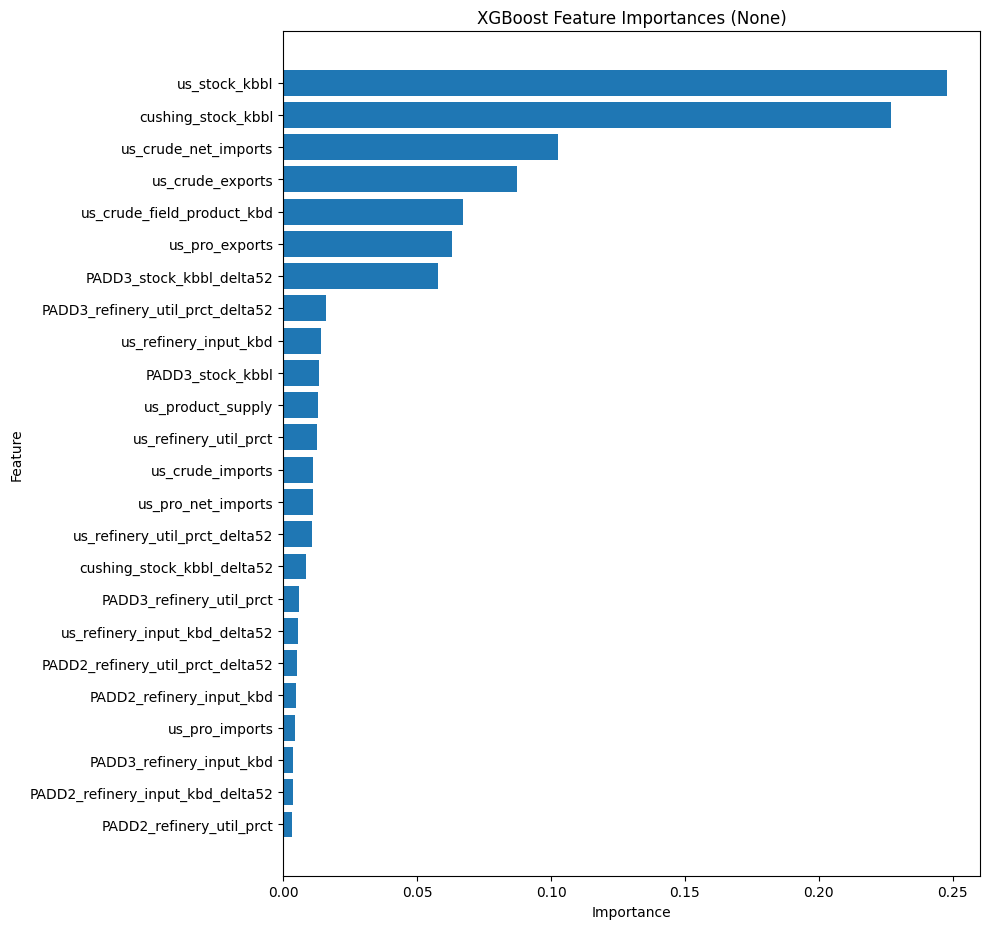

In [136]:
#Plot Importance

importance_type = getattr(best_xgb, "importance_type", "gain")  # usually "gain" by default
fi = pd.Series(best_xgb.feature_importances_, index=X_train.columns, name="importance")

# Sort
fi_sorted = fi.sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 0.35 * len(fi_sorted) + 1))
plt.barh(fi_sorted.index, fi_sorted.values)
plt.title(f"XGBoost Feature Importances ({importance_type})")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

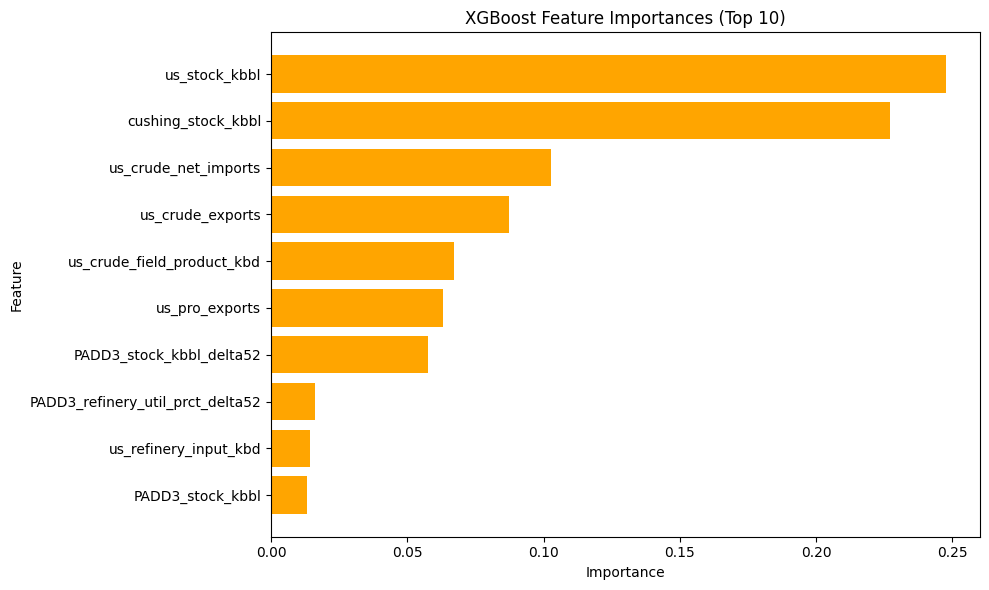

In [141]:
# Top-10 XGBoost feature importances
importance_type = getattr(best_xgb, "importance_type", "gain")
fi = pd.Series(best_xgb.feature_importances_, index=X_train.columns, name="importance")

# sort so biggest is at the top in barh
top10 = fi.nlargest(10).sort_values(ascending=True)

plt.figure(figsize=(10, 6), )
plt.barh(top10.index, top10.values, color='orange')
plt.title(f"XGBoost Feature Importances (Top 10)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()